# UNET network - Armand K



**Sources & Documentation**
- UNET paper: https://arxiv.org/abs/1505.04597

- UNET Network: https://github.com/jvanvugt/pytorch-unet/blob/master/unet.py

- Binary Cross-Entropy Loss: https://www.jeremyjordan.me/semantic-segmentation/#loss

- Dice loss: https://github.com/hubutui/DiceLoss-PyTorch/blob/master/loss.py




## Competition Subject: Binary segmentation of nuclei from cell images

Segmentation of cell nucleus from histopathological image, has been a focus of clinical practice and scientific research for more than half a century. 

The automated nucleus segmentation is fundamental for other tasks, which  lead to a valuable insight into the cell features. 

Those can result in early diagnosis of diseases such as breast cancer and brain tumour.



<img src = "https://drive.google.com/uc?id=1FGUxsxd5CV7nCZAaP8SBYEcFd8amajHM" class="centerImage">

<img src = "https://drive.google.com/uc?id=1wMjeYxdZG4ImAlmB0b2vYjfr00ihgTXj" class="centerImage">

## 0 - Setting up the Environment 

###  Connecting to Google Drive

In [ ]:
from google.colab import drive

drive = drive.mount('/content/drive')
save_folder = "/content/drive/MyDrive/ESSEC_Google_Drive/Cours 4ième trimestre/Intro to Deep Learning/Kaggle Competition"

Mounted at /content/drive


### Import of modules

In [ ]:
# Pytorch Modules
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchsummary import summary

# Image processing modules
import PIL.Image
import cv2

# Other Python Modules
from tqdm.notebook import tqdm
from IPython.display import Image
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Setting up the device (GPU)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


## 1 - Dataset & Dataloader

### Custom **Dataset** Class (loads and enables image transformations)

In [ ]:
root = 'drive/MyDrive/ESSEC_Google_Drive/Cours 4ième trimestre/Intro to Deep Learning/Kaggle Competition/'
print(root)

drive/MyDrive/ESSEC_Google_Drive/Cours 4ième trimestre/Intro to Deep Learning/Kaggle Competition/


Transform Classes

In [ ]:
# HORIZONTAL FLIPS
class RandomHorizontalFlip(nn.Module):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        """ Works on  tensors and PIL Images"""
        seed = np.random.randint(233)
        random.seed(seed)

        if random.random() < self.prob:
            image = TF.hflip(image)
            target = TF.hflip(target)

        return image, target

# VERTICAL FLIPS
class RandomVerticalFlip(nn.Module):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        """ Works on  tensors and PIL Images"""
        seed = np.random.randint(233)
        random.seed(seed)

        if random.random() < self.prob:
            image = TF.vflip(image)
            target = TF.vflip(target)

        return image, target

# ROTATIONS - NOTE: Only works if angle is 90 degrees, otherwise, introduces black pixels
class RandomRotation(nn.Module):
    def __init__(self, prob, angle=90):
        self.prob = prob
        self.angle = angle

    def __call__(self, image, target):
        """ Works on  tensors and PIL Images"""

        if random.random() < self.prob:
            image = TF.rotate(image, self.angle) 
            target = TF.rotate(target, self.angle)

        return image, target


# ADJUST BRIGHTNESS - NOTE: Over 1.1, 1.2, image is a lot too bright   
class RandomBrightnessChange(nn.Module):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image):
        """ Works on  tensors and PIL Images"""

        if random.random() < self.prob:
            color_coef = random.uniform(0.95, 1.05)
            image = TF.adjust_brightness(image, color_coef)

        return image

# ADJUST CONTRAST
class RandomContrastChange(nn.Module):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image):
        """ Works on  tensors and PIL Images"""

        if random.random() < self.prob:
            color_coef = random.uniform(0.95, 1.05)
            image = TF.adjust_contrast(image, color_coef)

        return image


In [ ]:
class MyDataset(Dataset):
    def __init__(self, root, train=True):
        # initialize
        self.root = root
        self.imgs = list(sorted(os.listdir(os.path.join(root, "train_images/train_images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "train_masks/train_masks"))))
        self.train = train
    
    def __getitem__(self, idx):
        ## Get the image-label set 
        img_path = os.path.join(self.root, "train_images/train_images", self.imgs[idx])
        mask_path = os.path.join(self.root, "train_masks/train_masks", self.masks[idx])
        
        ## Open images
        image = cv2.imread(img_path,1)
        image = PIL.Image.fromarray(image)  
        
        ## Open masks
        mask = cv2.imread(mask_path,0) # 0 to read as grayscale
        mask = cv2.threshold(mask,2,1,cv2.THRESH_BINARY)[1]
        mask = mask.astype('float64')
        mask = PIL.Image.fromarray(mask)

        # transforms
        if self.train:
            # Random Horizontal Flip
            random_hflip = RandomHorizontalFlip(0.2)
            image, mask = random_hflip(image, mask)

            # Random Vertical Flip
            random_vflip = RandomVerticalFlip(0.2)
            image, mask = random_vflip(image, mask)

            # Random 90 degrees Rotation 
            # random_rot = RandomRotation(0.2)
            # image, mask = random_rot(image, mask)

            # Random Brightness Change
            random_brightness = RandomBrightnessChange(0.3)
            image = random_brightness(image)

            # # Random Contrast Change
            # random_contrast = RandomContrastChange(0.3)
            # image = random_contrast(image)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        return image, mask

    def __len__(self):
        ## return the total number of data samples
        return len(self.imgs)


    def check_path(self, idx):
        """ Returns the path of the image and mask, for one index.
            To Check if the image path correspond to the right mask"""
        print("Image: ",self.imgs[idx])
        print("Mask: ", self.masks[idx])
        

In [ ]:
# Creating 2 datasets
dataset_main = MyDataset(root, train=True)
dataset_test = MyDataset(root, train=False)

In [ ]:
print("Dataset_main (WITH transforms) has {} samples".format(len(dataset_main)))
print("Dataset_test (WITHOUT transforms) has {} samples".format(len(dataset_test)))


Dataset_main (WITH transforms) has 2538 samples
Dataset_test (WITHOUT transforms) has 2538 samples


In [ ]:
print("Values in the mask: ", torch.unique(dataset_test[1][1]))
print("Path of image & mask n°100 in main dataset")
dataset_main.check_path(99)

print("Path of image & mask n°200 in main dataset")
dataset_test.check_path(199)

Values in the mask:  tensor([0., 1.])
Path of image & mask n°100 in main dataset
Image:  00100.png
Mask:  00100.png
Path of image & mask n°200 in main dataset
Image:  00200.png
Mask:  00200.png


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


### Split in Train, Validation & Test  sets 

In [ ]:
train_proportion = 0.65   # About 1650 samples
val_proportion = 0.8    # 15%: about 380 samples > test set of 761 images

train_size = int(len(dataset_main) * train_proportion)
val_size = int(len(dataset_main) * val_proportion)
test_size = len(dataset_main)

print("TRAINING: {} samples, {:.2%} of the dataset".format(train_size, 
                                                       train_proportion))

print("VALIDATION: {} samples, {:.2%} of the dataset".format(val_size-train_size, 
                                                         val_proportion-train_proportion))

print("TESTING: {} samples, {:.2%} of the dataset".format(test_size-val_size, 
                                                         1-val_proportion))


TRAINING: 1649 samples, 65.00% of the dataset
VALIDATION: 381 samples, 15.00% of the dataset
TESTING: 508 samples, 20.00% of the dataset


In [ ]:
torch.manual_seed(3)
indices = torch.randperm(len(dataset_main)).tolist()
len(indices[:train_size]), len(indices[train_size:val_size]), len(indices[val_size:])

(1649, 381, 508)

In [ ]:
# Set random seed
torch.manual_seed(3)
indices = torch.randperm(len(dataset_main)).tolist()

# split the dataset in train, val, and test set
train_dataset = torch.utils.data.Subset(dataset_main, indices[:train_size])
val_dataset = torch.utils.data.Subset(dataset_test, indices[train_size:val_size])
test_dataset = torch.utils.data.Subset(dataset_test, indices[val_size:test_size])

In [ ]:
print("Training {}, Validation {}, Testing {}".format(len(train_dataset), len(val_dataset), len(test_dataset)))
print("Total: {}".format(len(train_dataset) + len(val_dataset) + len(test_dataset)))

Training 1649, Validation 381, Testing 508
Total: 2538


In [ ]:
train_dataset[1][1].shape

torch.Size([1, 256, 256])

### Creating the 3 Dataloader

In [ ]:
# pass to Pytorch Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=2)

In [ ]:
# Checking that the right sets are in the right dataloaders, by checking the size
print("Training {}, Validation {}, Testing {}".format(len(train_dataloader), len(val_dataloader), len(test_dataloader)))
print("Total (Nbr of Batches): {}".format(len(train_dataloader) + len(val_dataloader) + len(test_dataloader)))


Training 330, Validation 77, Testing 102
Total (Nbr of Batches): 509


In [ ]:
# testing the dataloader
for i, (img, mask) in enumerate(train_dataloader):
    print("image: ",img.shape)
    print("mask: ",mask.shape,"\n")
    
    if i == 0:
      break

image:  torch.Size([5, 3, 256, 256])
mask:  torch.Size([5, 1, 256, 256]) 



## 2 - U-NET 

### U-Net Class

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        drop=False,
        up_mode='upconv',
    ):
        """
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        self.drop = drop
        self.d1 = nn.Dropout2d(p=0.2)
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)
        if self.drop:
          x = self.d1(x)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1]) # up is one UNetUpBlock forward pass

        if self.drop:
          x = self.d1(x)
        
        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)

        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)
        
        #print(out)

        return out

### Verifying that the UNET class works well

In [ ]:
# Initialization
model = UNet(in_channels=3, n_classes=1, depth=4, wf=5,padding=True).to(device)

In [ ]:
# summary gives us the feature maps size after each layer, and 
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 32, 256, 256]           9,248
              ReLU-4         [-1, 32, 256, 256]               0
     UNetConvBlock-5         [-1, 32, 256, 256]               0
            Conv2d-6         [-1, 64, 128, 128]          18,496
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
              ReLU-9         [-1, 64, 128, 128]               0
    UNetConvBlock-10         [-1, 64, 128, 128]               0
           Conv2d-11          [-1, 128, 64, 64]          73,856
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
             ReLU-14          [-1, 128,

In [ ]:
# Verifying the output shape
for i, batch, in enumerate(train_dataloader):
    img_batch, mask_batch = batch
    img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
    output = model(img_batch.float()).to(device)

    print("Input Image shape: ", img_batch.shape)
    print("Input Mask shape: ",mask_batch.shape,"\n")
    print("Output - Mask prediction shape", output.shape)
    if i == 0: 
      break


Input Image shape:  torch.Size([5, 3, 256, 256])
Input Mask shape:  torch.Size([5, 1, 256, 256]) 

Output - Mask prediction shape torch.Size([5, 1, 256, 256])


## 3 - Functions for visualization & training

### *Vizualization function*: to visualize the images and predictions

In [ ]:
def show_all(dataset, idx, unet, threshold=0.5):
    """Takes as input the image index. 
     Returns the Actual Image, the Mask, and our prediction"""

    # Read the image and mask of the picture indexed
    img_,  msk = dataset[idx]
    #msk = dataset[idx][1]

    # Predict
    img = torch.tensor(img_).to(device)
    pred = unet(img[None,:,:,:].float())
    
    with torch.no_grad():
      # Map values to [0;1] using sigmoid (1) & mask to binary
      pred = torch.sigmoid(pred.float())   
      pred = torch.where(pred>threshold, 1., 0.)

    # Extract mask in the relevant format
    pred = pred.detach().cpu().numpy()
    pred = pred[0,0]

    # Format to plot
    img_ = np.transpose(img_, (1, 2, 0))

    #img_ = img_*255.
    msk = msk.reshape(256, 256)

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15,15))
    axs[0].imshow(img_)
    axs[0].set_title('Actual image')
    axs[1].imshow(msk, cmap ="gray")
    axs[1].set_title('Mask')
    axs[2].imshow(pred, cmap ="gray")
    axs[2].set_title('Mask Prediction')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


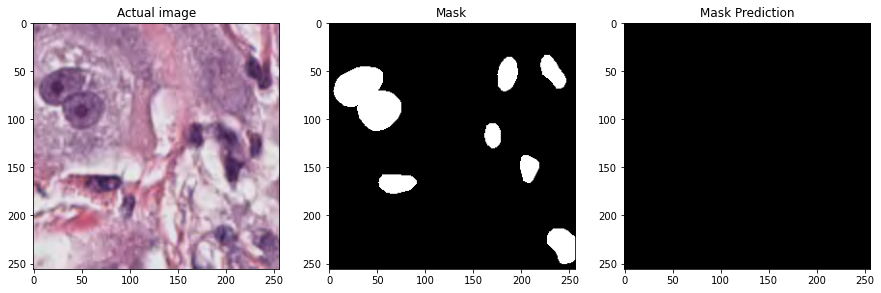

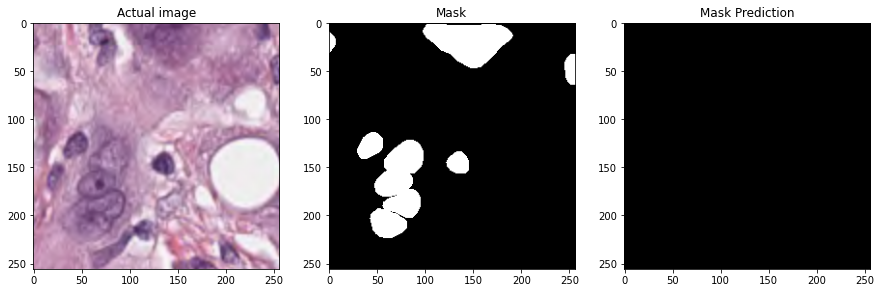

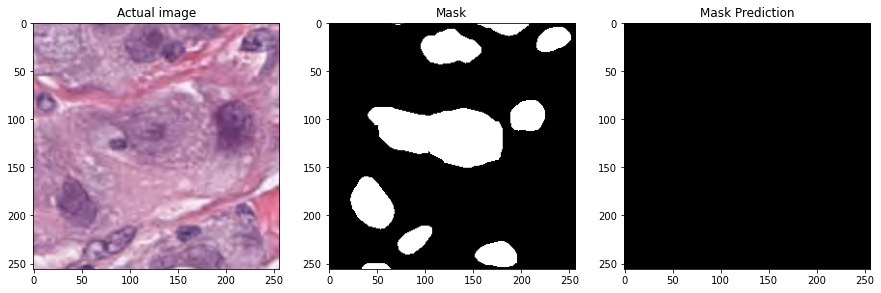

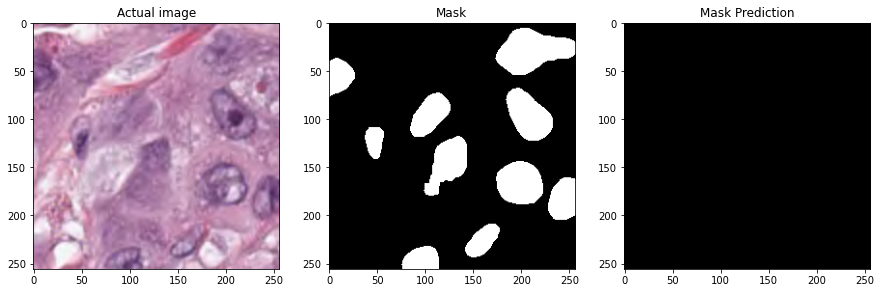

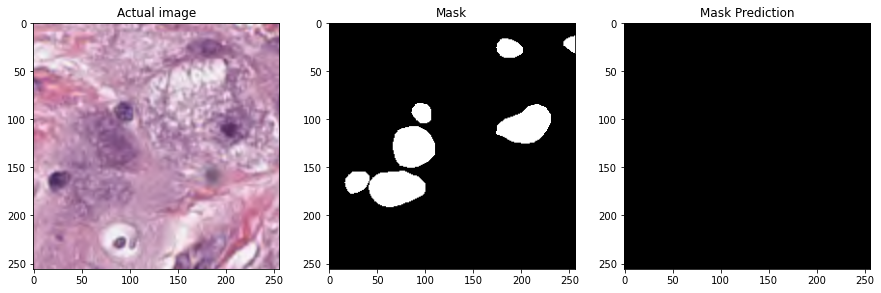

In [ ]:
# Implementation on the 8th image
for i in range(0, 5):
    show_all(dataset_main, i, model, 0.5)

### *Training functions*: to run the training, save the hyperparameters & loss curves, ...

In [ ]:
def training_unet(unet_model, train_dl, val_dl, save_folder, device_used, 
                  optim, criterion, epochs=10, dice_loss=True, depth=5, wf=6, up="upconv", 
                  dropout=False):
      """Function which performs the training of the model's parameters
      Args:
        - Model config: unet_model, depth, wf, up, dropout
        - Training config: epochs, optim, criterion
        - Others: device (gpu/cpu), train_dl (train_dataloader), val_dl(val_dataloaderr)

      Returns:
        - total_train_loss = []: list of average loss on training set per epoch
        - total_val_loss = []: list of average loss on tvalidation set per epoch
        
        """
      # Save txt file of the configs in the drive
      write_config(save_folder, epochs, depth, wf, up, dropout)
      
      # list of losses
      total_train_loss = []
      total_val_loss = []

      for epoch in tqdm(range(epochs)):
          #---------------------------Training Set---------------------------#
          model.train()
          loss_per_epoch = []    

          for i, (X, y) in enumerate(tqdm(train_dl)):
              X = X.to(device_used)  # [N, 1, H, W]
              y = y.to(device_used)  # [N, H, W] with class indices (0, 1)

              # zero gradient
              optim.zero_grad()
              # Predict
              prediction = model(X.float())  # [N, 2, H, W]
              
              if dice_loss:
                  y = y.squeeze(1)
              
              # Compute loss    
              loss = criterion(prediction, y.float())
              #print(loss)

              # backpropogate
              loss.backward()
              optim.step()

              # add loss to list
              loss_per_epoch.append(loss.item())

    
          model.eval()
          #---------------------------VALIDATION SET---------------------------#
          valloss_per_epoch = []
          for Xval, yval in tqdm(val_dl):
              Xval = Xval.to(device_used)  # [N, 1, H, W]
              yval = yval.to(device_used)  # [N, H, W] with class indices (0, 1)
          
              with torch.no_grad():
                 prediction_val = model(Xval.float())  # [N, 2, H, W]
          
              if dice_loss:
                  y = y.squeeze(1)
          
              loss = criterion(prediction_val, yval)
              #print(loss)
          
          valloss_per_epoch.append(loss.item())

          # average loss    
          train_loss_mean = np.mean(loss_per_epoch)  
          val_loss_mean = np.mean(valloss_per_epoch)

          # add to list of loss
          total_train_loss.append(train_loss_mean)   
          total_val_loss.append(val_loss_mean)

          print("\nEpoch n°{}".format(epoch+1))
          print("- average TRAINING loss = ",train_loss_mean)
          print("- average VALIDATION loss = ",val_loss_mean)

          # Save the model
          torch.save(model.state_dict(), save_folder + 
                  '/UNET_epoch{}.pt'.format(epoch+1))
      
      return total_train_loss, total_val_loss


In [ ]:
def save_graph(loss, nb_epochs, save_folder, validation=False):
    """ Function to save the Training or Validation loss curves"""
    plt.plot(list(range(nb_epochs+1))[1:], loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if validation:
        plt.title("Validation Loss")
        plt.savefig('{}/chart_Validation.png'.format(save_folder))
    else:
        plt.title("Training Loss")
        plt.savefig('{}/chart_Training.png'.format(save_folder))

In [ ]:
def write_config(save_folder, epoch=10, depth=5, wf=6, up = "upconv", dropout=False):
    """ Function to save the configuration of the UNET used during training
        (hyperparameters, optimizer, ..."""
    ff=open('{}/config.txt'.format(save_folder),'a')
    ff.write(' Number of epochs: ')
    ff.write(str(epoch))
    ff.write('\n')
    ff.write('Depth : ')
    ff.write(str(depth))
    ff.write('\n')
    ff.write(' wf (Order of filters): ')
    ff.write(str(wf))
    ff.write('\n')
    ff.write(' up layer used: ')
    ff.write(up)
    ff.write('\n')
    ff.write(' dropout used?: ')
    if dropout:
      ff.write("Yes")
    else:
      ff.write("No")
    ff.write('\n')

### *Loss functions*: Pixel-wise BCE Loss

In [ ]:
# Trying out the BCE loss
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(4.6 / 1)]))
criterion.to(device)
criterion(output, mask_batch.float())

#mask_batch.squeeze(1).shape
print("BCE Loss for one batch: ", criterion(output, mask_batch.float()))

BCE Loss for one batch:  tensor(1.2762, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


#### Checking if there is *class imbalance*


Imbalance was found: for every pixel labeled 1, there are 4.7 black pixels: this is added to the **pos_weight** parameter in the loss function used. 

If the pos_weight parameter is not added, the neural network will often predict everything to be black (as we have experienced). This is why it is important to "penalize" the loss if it labels a "1" as a "0".

In [ ]:
ones_ratio = []

for i, (x, y) in enumerate(tqdm(val_dataloader)):
    ratio = torch.sum(y)/ torch.numel(y)
    ones_ratio.append(ratio.item())

1 / (np.mean(ones_ratio) / (1 - np.mean(ones_ratio))) 


### *Loss Functions*: DICE Loss


$$Dice \ Loss = 1 -  \frac{2* |X \cap Y| }{|X| + |Y| +1} $$

In [ ]:
class DiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
    """
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predict, target):
        # Sigmoid(output) so that values are in [0;1]
        predict = torch.sigmoid(predict)

        #flatten the tensors
        predict = predict.view(-1)
        target = target.view(-1)
        inter = (predict*target).sum()
    
        dice_loss = 1-((2. * inter) /(predict.sum() + target.sum() + self.smooth))
        #dice_loss.requires_grad = True
        
        return dice_loss


In [ ]:
def dice_loss(output, target):
    # Sigmoid(output) so that values are in [0;1]
    output = torch.sigmoid(output)

    output = output.view(-1)
    target = target.view(-1)
    inter = (output* target).sum()
    smooth = 1.
    
    dice_loss = 1-((2. * inter) /(output.sum() + target.sum() + smooth))
    #dice_loss.requires_grad=True
    
    return dice_loss

In [ ]:
# Testing the Class and the function
crit = DiceLoss()
print("Dice Loss on output of the model (Class): ", crit(output, mask_batch))
print("Dice Loss on output of the model (Function): ",dice_loss(output, mask_batch.float()))

Dice Loss on output of the model (Class):  tensor(0.6436, device='cuda:0', grad_fn=<RsubBackward1>)
Dice Loss on output of the model (Function):  tensor(0.6436, device='cuda:0', grad_fn=<RsubBackward1>)


### *Evaluation functions*: Computing the DICE Score

$$Dice Score = \frac{2*|X \cap Y|}{|X| + |Y|}$$

with X: predicted set of pixels,
Y: the ground truth


In [ ]:
# Compute the dice for 1
def dice_score(output, target, threshold):
    output = torch.sigmoid(output)
    
    output = torch.where(output>threshold, 1., 0.)
    output = output.view(-1)
    target = target.view(-1)
    inter = (output* target).sum()
    smooth = 1.
    
    dice = (2. * inter) /(output.sum() + target.sum() + smooth)
    dice = dice.detach().cpu().numpy()
    
    return dice


In [ ]:
# Computing the dice score for the whole set
def compute_dice(dataloader, model_unet, threshold):
    dice_list = []
    for i, (X, y) in enumerate(tqdm(dataloader)):
        X = X.to(device)  # [N, 1, H, W]
        y = y.to(device)  # [N, H, W] with class indices (0, 1)
        with torch.no_grad():
            prediction = model_unet(X.float())  # [N, 2, H, W]
        
        y = y.squeeze(1)
        score = dice_score(prediction, y, threshold)
        print(score)
        dice_list.append(score)
        
    final_dice = np.mean(dice_list)
    print("\nDice Score: {:.1%}".format(final_dice))

    return final_dice
        

### *Evaluation function*: returns a binary mask for an image, using a unet model

In [ ]:
def predict_mask(unet, image_path, threshold):
    """ reads image path (/xxx.png)
    returns the prediction of the mask for this image as a numpy array"""
    # Read path and transform into 3D array
    image = cv2.imread(image_path,1)

    # Order and divide by 255. 
    image = np.transpose(image, (2,0,1)) 
    image = image/255.0

    # numpy array Image as tensor
    img = torch.tensor(image).to(device)

    # Predict
    pred = unet(img[None,:,:,:].float())

    with torch.no_grad():
      # Map values to [0;1] using sigmoid (1) & mask to binary
      pred = torch.sigmoid(pred.float())   
      pred = torch.where(pred>threshold, 1., 0.)

    # Extract mask in the relevant format
    pred = pred.detach().cpu().numpy()
    pred = pred[0].reshape(256,256)

    return pred

## 4 - Training 

### Training Using **BCE Loss**

In [ ]:
# Clear some gpu memory
torch.cuda.empty_cache()

In [ ]:
# Creating a folder where models will be saved
version = "1"
save_folder = "/content/drive/MyDrive/ESSEC_Google_Drive/Cours 4ième trimestre/Intro to Deep Learning/Kaggle Competition/models/BCELoss/UNET_2/models{}".format(version)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

print(save_folder)

/content/drive/MyDrive/ESSEC_Google_Drive/Cours 4ième trimestre/Intro to Deep Learning/Kaggle Competition/models/BCELoss/UNET_2/models1


#### Hyper-Parameters

In [ ]:
# UNET Model
model = UNet(in_channels=3, padding=True, n_classes=1,
             up_mode='upconv',wf=4, depth=4, batch_norm=True).to(device)

# Optimizer
optim = torch.optim.Adam(model.parameters())

# Criterion
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(4.7 / 1)]))
criterion.to(device)

# Others
epochs = 10

In [ ]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
              ReLU-2         [-1, 16, 256, 256]               0
       BatchNorm2d-3         [-1, 16, 256, 256]              32
            Conv2d-4         [-1, 16, 256, 256]           2,320
              ReLU-5         [-1, 16, 256, 256]               0
       BatchNorm2d-6         [-1, 16, 256, 256]              32
     UNetConvBlock-7         [-1, 16, 256, 256]               0
            Conv2d-8         [-1, 32, 128, 128]           4,640
              ReLU-9         [-1, 32, 128, 128]               0
      BatchNorm2d-10         [-1, 32, 128, 128]              64
           Conv2d-11         [-1, 32, 128, 128]           9,248
             ReLU-12         [-1, 32, 128, 128]               0
      BatchNorm2d-13         [-1, 32, 128, 128]              64
    UNetConvBlock-14         [-1, 32, 1

#### **BCE-LOSS**: Training and results

In [ ]:
train_loss, val_loss = training_unet(model, train_dataloader, val_dataloader, save_folder, device,
              optim, criterion, epochs=10,depth=4, wf=4, dice_loss=False)

tensor(1.1562, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2291, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.4742, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1711, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0636, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9978, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1625, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1864, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9124, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7937, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8650, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2073, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0775, device='cuda:0', grad_fn=

tensor(0.9326, device='cuda:0')
tensor(0.9303, device='cuda:0')
tensor(0.7810, device='cuda:0')
tensor(0.9681, device='cuda:0')
tensor(0.8990, device='cuda:0')
tensor(0.7834, device='cuda:0')
tensor(0.8382, device='cuda:0')
tensor(0.7300, device='cuda:0')
tensor(1.0062, device='cuda:0')
tensor(0.7708, device='cuda:0')
tensor(0.7505, device='cuda:0')
tensor(0.6895, device='cuda:0')
tensor(0.8096, device='cuda:0')
tensor(0.6787, device='cuda:0')
tensor(0.8672, device='cuda:0')
tensor(0.5336, device='cuda:0')
tensor(0.8173, device='cuda:0')
tensor(0.6633, device='cuda:0')
tensor(0.8149, device='cuda:0')
tensor(1.0363, device='cuda:0')
tensor(0.9350, device='cuda:0')
tensor(0.8078, device='cuda:0')
tensor(0.7385, device='cuda:0')
tensor(0.8909, device='cuda:0')
tensor(0.5918, device='cuda:0')
tensor(1.0351, device='cuda:0')
tensor(0.9654, device='cuda:0')
tensor(0.7767, device='cuda:0')
tensor(0.8729, device='cuda:0')
tensor(0.7716, device='cuda:0')
tensor(0.8448, device='cuda:0')
tensor(0

tensor(0.8995, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2506, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9816, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0479, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9741, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0808, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8557, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2077, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9378, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.4752, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.3067, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7977, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0504, device='cuda:0', grad_fn=

tensor(0.9506, device='cuda:0')
tensor(0.9262, device='cuda:0')
tensor(0.7605, device='cuda:0')
tensor(0.9791, device='cuda:0')
tensor(0.8744, device='cuda:0')
tensor(0.7524, device='cuda:0')
tensor(0.8511, device='cuda:0')
tensor(0.7197, device='cuda:0')
tensor(1.0072, device='cuda:0')
tensor(0.7528, device='cuda:0')
tensor(0.7356, device='cuda:0')
tensor(0.6742, device='cuda:0')
tensor(0.7702, device='cuda:0')
tensor(0.6712, device='cuda:0')
tensor(0.8584, device='cuda:0')
tensor(0.5177, device='cuda:0')
tensor(0.8042, device='cuda:0')
tensor(0.6616, device='cuda:0')
tensor(0.7975, device='cuda:0')
tensor(0.9936, device='cuda:0')
tensor(0.9412, device='cuda:0')
tensor(0.8037, device='cuda:0')
tensor(0.7203, device='cuda:0')
tensor(0.8703, device='cuda:0')
tensor(0.5850, device='cuda:0')
tensor(1.0646, device='cuda:0')
tensor(0.9693, device='cuda:0')
tensor(0.7499, device='cuda:0')
tensor(0.8575, device='cuda:0')
tensor(0.7651, device='cuda:0')
tensor(0.8541, device='cuda:0')
tensor(0

tensor(1.0908, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8976, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0788, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8358, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8715, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0954, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0616, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9586, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0623, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0512, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8615, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1633, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1941, device='cuda:0', grad_fn=

tensor(1.0685, device='cuda:0')
tensor(0.9301, device='cuda:0')
tensor(0.8120, device='cuda:0')
tensor(0.9994, device='cuda:0')
tensor(0.8709, device='cuda:0')
tensor(0.7904, device='cuda:0')
tensor(0.8952, device='cuda:0')
tensor(0.7742, device='cuda:0')
tensor(1.1420, device='cuda:0')
tensor(0.7858, device='cuda:0')
tensor(0.7191, device='cuda:0')
tensor(0.6847, device='cuda:0')
tensor(0.7879, device='cuda:0')
tensor(0.6583, device='cuda:0')
tensor(0.8832, device='cuda:0')
tensor(0.5255, device='cuda:0')
tensor(0.8599, device='cuda:0')
tensor(0.6489, device='cuda:0')
tensor(0.8091, device='cuda:0')
tensor(1.0007, device='cuda:0')
tensor(0.9554, device='cuda:0')
tensor(0.8256, device='cuda:0')
tensor(0.7243, device='cuda:0')
tensor(0.8722, device='cuda:0')
tensor(0.5680, device='cuda:0')
tensor(1.1382, device='cuda:0')
tensor(1.0280, device='cuda:0')
tensor(0.7581, device='cuda:0')
tensor(0.9006, device='cuda:0')
tensor(0.7738, device='cuda:0')
tensor(0.9583, device='cuda:0')
tensor(0

tensor(0.9277, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8235, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9188, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1874, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2258, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7852, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.3712, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2383, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9398, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1601, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9538, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0486, device='cuda:0', grad_fn=

tensor(0.8747, device='cuda:0')
tensor(0.8568, device='cuda:0')
tensor(0.7288, device='cuda:0')
tensor(0.9300, device='cuda:0')
tensor(0.8042, device='cuda:0')
tensor(0.7161, device='cuda:0')
tensor(0.7874, device='cuda:0')
tensor(0.6824, device='cuda:0')
tensor(0.9751, device='cuda:0')
tensor(0.7242, device='cuda:0')
tensor(0.6788, device='cuda:0')
tensor(0.6206, device='cuda:0')
tensor(0.7236, device='cuda:0')
tensor(0.6228, device='cuda:0')
tensor(0.7896, device='cuda:0')
tensor(0.4729, device='cuda:0')
tensor(0.7627, device='cuda:0')
tensor(0.6055, device='cuda:0')
tensor(0.7525, device='cuda:0')
tensor(0.9623, device='cuda:0')
tensor(0.8940, device='cuda:0')
tensor(0.7233, device='cuda:0')
tensor(0.6881, device='cuda:0')
tensor(0.8043, device='cuda:0')
tensor(0.5155, device='cuda:0')
tensor(1.0068, device='cuda:0')
tensor(0.9174, device='cuda:0')
tensor(0.7042, device='cuda:0')
tensor(0.7952, device='cuda:0')
tensor(0.7039, device='cuda:0')
tensor(0.8084, device='cuda:0')
tensor(0

tensor(1.3383, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1844, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9935, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.3159, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9073, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8616, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1516, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6950, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9148, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0173, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2218, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1804, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9710, device='cuda:0', grad_fn=

tensor(0.8505, device='cuda:0')
tensor(0.8007, device='cuda:0')
tensor(0.6903, device='cuda:0')
tensor(0.9547, device='cuda:0')
tensor(0.7524, device='cuda:0')
tensor(0.6677, device='cuda:0')
tensor(0.7723, device='cuda:0')
tensor(0.6667, device='cuda:0')
tensor(0.9301, device='cuda:0')
tensor(0.7091, device='cuda:0')
tensor(0.6802, device='cuda:0')
tensor(0.5954, device='cuda:0')
tensor(0.6872, device='cuda:0')
tensor(0.6321, device='cuda:0')
tensor(0.7753, device='cuda:0')
tensor(0.4859, device='cuda:0')
tensor(0.7356, device='cuda:0')
tensor(0.6065, device='cuda:0')
tensor(0.7244, device='cuda:0')
tensor(0.9351, device='cuda:0')
tensor(0.8614, device='cuda:0')
tensor(0.6952, device='cuda:0')
tensor(0.6792, device='cuda:0')
tensor(0.7686, device='cuda:0')
tensor(0.5231, device='cuda:0')
tensor(0.9849, device='cuda:0')
tensor(0.8738, device='cuda:0')
tensor(0.6750, device='cuda:0')
tensor(0.7545, device='cuda:0')
tensor(0.6768, device='cuda:0')
tensor(0.7754, device='cuda:0')
tensor(0

tensor(0.9542, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1219, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0762, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0718, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8772, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.3031, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9751, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8434, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1930, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9980, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9969, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9397, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9013, device='cuda:0', grad_fn=

tensor(0.8691, device='cuda:0')
tensor(0.7905, device='cuda:0')
tensor(0.6821, device='cuda:0')
tensor(0.9698, device='cuda:0')
tensor(0.7707, device='cuda:0')
tensor(0.6526, device='cuda:0')
tensor(0.8296, device='cuda:0')
tensor(0.6934, device='cuda:0')
tensor(0.9244, device='cuda:0')
tensor(0.7177, device='cuda:0')
tensor(0.6808, device='cuda:0')
tensor(0.6024, device='cuda:0')
tensor(0.6567, device='cuda:0')
tensor(0.6525, device='cuda:0')
tensor(0.8122, device='cuda:0')
tensor(0.5171, device='cuda:0')
tensor(0.7514, device='cuda:0')
tensor(0.6774, device='cuda:0')
tensor(0.7323, device='cuda:0')
tensor(0.8963, device='cuda:0')
tensor(0.8806, device='cuda:0')
tensor(0.7186, device='cuda:0')
tensor(0.7111, device='cuda:0')
tensor(0.7950, device='cuda:0')
tensor(0.5381, device='cuda:0')
tensor(0.9646, device='cuda:0')
tensor(0.8923, device='cuda:0')
tensor(0.6800, device='cuda:0')
tensor(0.7518, device='cuda:0')
tensor(0.7041, device='cuda:0')
tensor(0.7618, device='cuda:0')
tensor(0

tensor(1.1201, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8785, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1789, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1343, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8765, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1180, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2789, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1729, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0494, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9128, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7743, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0001, device='cuda:0', grad_fn=

tensor(0.8804, device='cuda:0')
tensor(0.8103, device='cuda:0')
tensor(0.7100, device='cuda:0')
tensor(0.9471, device='cuda:0')
tensor(0.7475, device='cuda:0')
tensor(0.6960, device='cuda:0')
tensor(0.7918, device='cuda:0')
tensor(0.6886, device='cuda:0')
tensor(0.9563, device='cuda:0')
tensor(0.6851, device='cuda:0')
tensor(0.6701, device='cuda:0')
tensor(0.5948, device='cuda:0')
tensor(0.6935, device='cuda:0')
tensor(0.5973, device='cuda:0')
tensor(0.7749, device='cuda:0')
tensor(0.4742, device='cuda:0')
tensor(0.7639, device='cuda:0')
tensor(0.6018, device='cuda:0')
tensor(0.7410, device='cuda:0')
tensor(0.9137, device='cuda:0')
tensor(0.8353, device='cuda:0')
tensor(0.7171, device='cuda:0')
tensor(0.6628, device='cuda:0')
tensor(0.7768, device='cuda:0')
tensor(0.5128, device='cuda:0')
tensor(0.9717, device='cuda:0')
tensor(0.9096, device='cuda:0')
tensor(0.6748, device='cuda:0')
tensor(0.7944, device='cuda:0')
tensor(0.6909, device='cuda:0')
tensor(0.7844, device='cuda:0')
tensor(0

tensor(1.0497, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9583, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0903, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0881, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2546, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1316, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1628, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.2248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7848, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1147, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9974, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1318, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0168, device='cuda:0', grad_fn=

tensor(0.8823, device='cuda:0')
tensor(0.8659, device='cuda:0')
tensor(0.7429, device='cuda:0')
tensor(0.9070, device='cuda:0')
tensor(0.8010, device='cuda:0')
tensor(0.7372, device='cuda:0')
tensor(0.8001, device='cuda:0')
tensor(0.6928, device='cuda:0')
tensor(0.9618, device='cuda:0')
tensor(0.7461, device='cuda:0')
tensor(0.6902, device='cuda:0')
tensor(0.6520, device='cuda:0')
tensor(0.7399, device='cuda:0')
tensor(0.6396, device='cuda:0')
tensor(0.8258, device='cuda:0')
tensor(0.5027, device='cuda:0')
tensor(0.7779, device='cuda:0')
tensor(0.6262, device='cuda:0')
tensor(0.7825, device='cuda:0')
tensor(0.9604, device='cuda:0')
tensor(0.9412, device='cuda:0')
tensor(0.7549, device='cuda:0')
tensor(0.7121, device='cuda:0')
tensor(0.8316, device='cuda:0')
tensor(0.5427, device='cuda:0')
tensor(1.0020, device='cuda:0')
tensor(0.9277, device='cuda:0')
tensor(0.7382, device='cuda:0')
tensor(0.8160, device='cuda:0')
tensor(0.7174, device='cuda:0')
tensor(0.8209, device='cuda:0')
tensor(0

tensor(1.1766, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0538, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9938, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0107, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0605, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.8772, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9678, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.3885, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9434, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1541, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0306, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0589, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0043, device='cuda:0', grad_fn=

tensor(0.9019, device='cuda:0')
tensor(0.9060, device='cuda:0')
tensor(0.7257, device='cuda:0')
tensor(0.9569, device='cuda:0')
tensor(0.7831, device='cuda:0')
tensor(0.7070, device='cuda:0')
tensor(0.8198, device='cuda:0')
tensor(0.7030, device='cuda:0')
tensor(0.9677, device='cuda:0')
tensor(0.7686, device='cuda:0')
tensor(0.7115, device='cuda:0')
tensor(0.6474, device='cuda:0')
tensor(0.7281, device='cuda:0')
tensor(0.6625, device='cuda:0')
tensor(0.8585, device='cuda:0')
tensor(0.5207, device='cuda:0')
tensor(0.7743, device='cuda:0')
tensor(0.6544, device='cuda:0')
tensor(0.7622, device='cuda:0')
tensor(0.9307, device='cuda:0')
tensor(0.9721, device='cuda:0')
tensor(0.7585, device='cuda:0')
tensor(0.7219, device='cuda:0')
tensor(0.8282, device='cuda:0')
tensor(0.5490, device='cuda:0')
tensor(1.0471, device='cuda:0')
tensor(0.9414, device='cuda:0')
tensor(0.7207, device='cuda:0')
tensor(0.7914, device='cuda:0')
tensor(0.7220, device='cuda:0')
tensor(0.8193, device='cuda:0')
tensor(0

tensor(0.8241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9426, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9182, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9236, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1769, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1792, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0917, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.3235, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9538, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1223, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.0409, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(1.1372, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.9678, device='cuda:0', grad_fn=

tensor(0.9118, device='cuda:0')
tensor(0.8987, device='cuda:0')
tensor(0.8397, device='cuda:0')
tensor(0.9053, device='cuda:0')
tensor(0.8563, device='cuda:0')
tensor(0.8112, device='cuda:0')
tensor(0.7991, device='cuda:0')
tensor(0.7420, device='cuda:0')
tensor(0.9811, device='cuda:0')
tensor(0.7997, device='cuda:0')
tensor(0.7307, device='cuda:0')
tensor(0.7178, device='cuda:0')
tensor(0.8063, device='cuda:0')
tensor(0.6560, device='cuda:0')
tensor(0.8416, device='cuda:0')
tensor(0.5476, device='cuda:0')
tensor(0.8409, device='cuda:0')
tensor(0.6668, device='cuda:0')
tensor(0.8251, device='cuda:0')
tensor(0.9890, device='cuda:0')
tensor(0.9438, device='cuda:0')
tensor(0.8205, device='cuda:0')
tensor(0.7556, device='cuda:0')
tensor(0.8441, device='cuda:0')
tensor(0.5633, device='cuda:0')
tensor(1.0062, device='cuda:0')
tensor(0.9560, device='cuda:0')
tensor(0.7926, device='cuda:0')
tensor(0.8462, device='cuda:0')
tensor(0.7566, device='cuda:0')
tensor(0.8544, device='cuda:0')
tensor(0

#### Summary of the model & Visualization

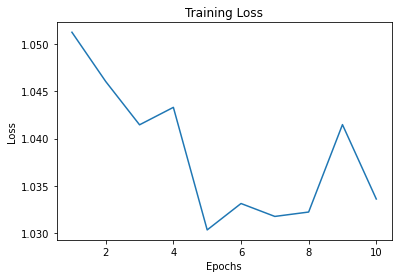

In [ ]:
save_graph(train_loss, epochs, save_folder, validation=False)

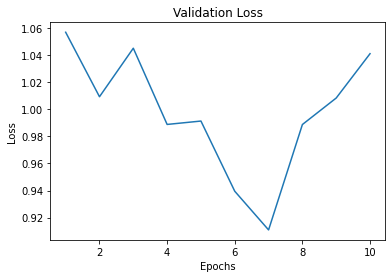

In [ ]:
save_graph(val_loss, epochs, save_folder, validation=True)

In [ ]:
# We load the best model
model = UNet(in_channels=3, padding=True, n_classes=1,
             up_mode='upconv',wf=4, depth=4, batch_norm=True).to(device)

nb = "7"
model_path = save_folder + "/UNET_epoch"+nb + ".pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


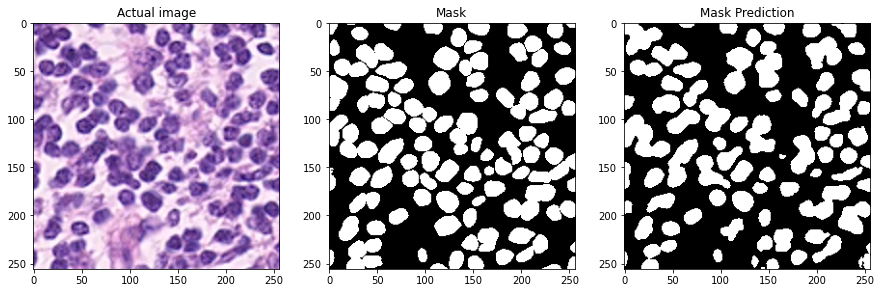

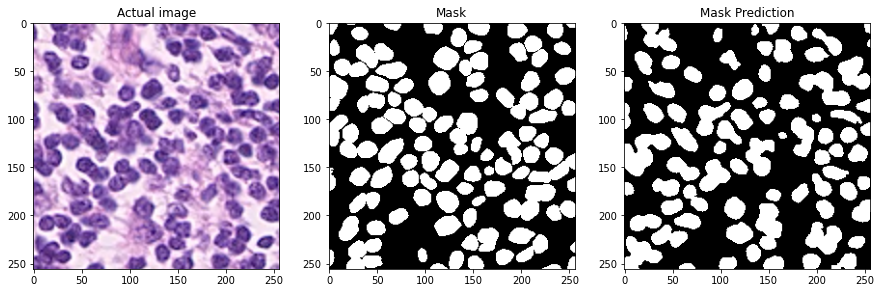

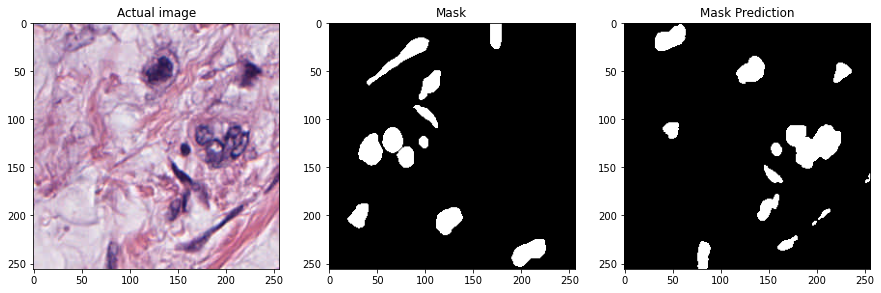

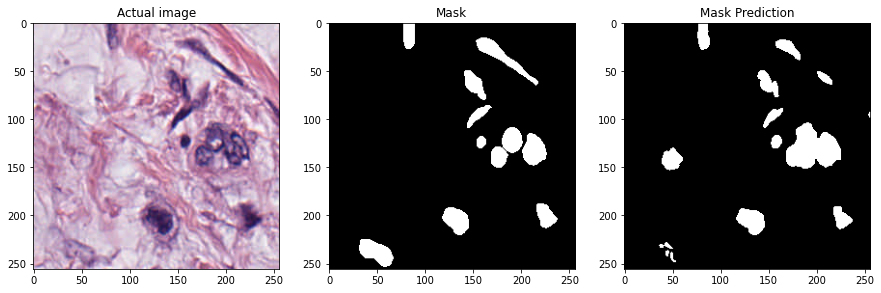

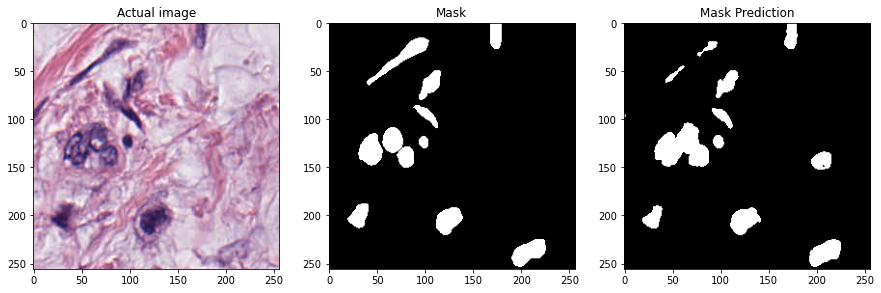

In [ ]:
show_all(test_dataset, 12, model, 0.5)
show_all(test_dataset, 12, model, 0.7)
show_all(test_dataset, 100, model, 0.5)
show_all(test_dataset, 100, model, 0.7)
show_all(test_dataset, 100, model, 0.63)

In [ ]:
compute_dice(test_dataloader, model, 0.8)

Choosing the best threshold

In [ ]:
total_dice_ = []
threshold = np.linspace(0.5,0.8,10)
for s in tqdm(threshold):
    dice_ = []
    model.eval()
    total_dice_.append(compute_dice(test_dataloader, model, s))

0.64877385
0.47143602
0.62266773
0.63546085
0.7070323
0.58336043
0.7220352
0.73615026
0.71026105
0.59415394
0.7282017
0.61493605
0.7594573
0.53620183
0.72222054
0.60442656
0.7031357
0.6235498
0.68243605
0.7140676
0.61352265
0.71955574
0.6747885
0.57487565
0.60615385
0.67453545
0.74386936
0.64897996
0.6437076
0.60973394
0.6006644
0.62842894
0.68423396
0.6445123
0.7062496
0.737548
0.68301225
0.7289805
0.69054663
0.691322
0.58708537
0.68272287
0.68979585
0.55260056
0.7936342
0.6899486
0.7308989
0.6725198
0.7428209
0.61041784
0.69543225
0.6782848
0.6124106
0.63701963
0.6366074
0.8240386
0.65756476
0.6343461
0.7636183
0.5641148
0.5912695
0.65456694
0.72807944
0.7304644
0.6530253
0.5607314
0.6791267
0.76625204
0.7235739
0.6785063
0.66546184
0.6046836
0.76148266
0.6057666
0.66323656
0.66272855
0.71246165
0.50136906
0.7056545
0.6573584
0.7684844
0.5997463
0.75694233
0.7539621
0.5914444
0.56828237
0.73436445
0.7936123
0.47510463
0.6528248
0.6695197
0.7647404
0.7166679
0.79243946
0.6788621
0.730

0.65637547
0.48545527
0.64200944
0.671548
0.7057124
0.63881034
0.746191
0.76141816
0.73238754
0.61486995
0.7527612
0.65422535
0.7837817
0.5819221
0.74069035
0.59928566
0.7271949
0.66384846
0.7122795
0.73967665
0.6535946
0.7305594
0.6870689
0.6345213
0.6232161
0.7031069
0.7712344
0.6801233
0.69452906
0.63048005
0.6393702
0.6470898
0.70630926
0.6623234
0.7284156
0.76594967
0.694927
0.77739805
0.7073922
0.70722616
0.6162303
0.7069131
0.7113708
0.5670868
0.7942583
0.713624
0.76250774
0.70593584
0.76762027
0.6351538
0.71492916
0.7022183
0.6361574
0.662725
0.6533045
0.83053815
0.6828964
0.6532497
0.78792673
0.58191234
0.61925834
0.674311
0.7523491
0.7580551
0.6702196
0.58538926
0.6960683
0.7821162
0.7411148
0.7067149
0.68230104
0.6297483
0.77612144
0.6344339
0.69331527
0.7045189
0.74949044
0.528904
0.7275778
0.67841184
0.7848
0.635613
0.7838006
0.77020746
0.6349905
0.586962
0.7590522
0.8015107
0.5136157
0.67970365
0.6693743
0.7762729
0.73069286
0.7999602
0.69728684
0.750154
0.744079
0.679054

0.6606094
0.48748747
0.6573532
0.70046383
0.6987543
0.67777485
0.75771576
0.77376395
0.74836713
0.6323852
0.76681876
0.6832549
0.802031
0.6188567
0.75021523
0.58350253
0.7455556
0.69595915
0.7332599
0.75537515
0.68270165
0.73294604
0.69302905
0.6770179
0.637566
0.7228364
0.7917345
0.7062291
0.7272635
0.6462436
0.6647754
0.6617896
0.7261481
0.6775735
0.7446829
0.7867308
0.70213217
0.8003206
0.7161023
0.7158551
0.6451912
0.7200426
0.72751015
0.57529163
0.78769207
0.7298615
0.7837429
0.73451525
0.78495663
0.6527936
0.72992474
0.7192928
0.65720797
0.6805262
0.6642867
0.82784784
0.7052075
0.66809165
0.80663806
0.5853887
0.64307666
0.6892251
0.7715516
0.77604336
0.6828817
0.60456854
0.7073201
0.79093105
0.75385183
0.724951
0.69530064
0.6498535
0.7853021
0.65987843
0.71588504
0.7343031
0.7696199
0.55599856
0.7417052
0.6919309
0.7912508
0.66400737
0.79842645
0.77953976
0.6632082
0.60097486
0.776918
0.8034668
0.5449553
0.69874746
0.6649183
0.78070366
0.73967665
0.80090696
0.7104939
0.76521844
0

0.65867126
0.48164576
0.6699275
0.72272617
0.6833793
0.7049986
0.75838196
0.77419776
0.757987
0.6465869
0.7727442
0.70628726
0.8160168
0.65117043
0.75365096
0.5572907
0.7584288
0.72402984
0.7482708
0.7627107
0.7082186
0.72728616
0.6888044
0.7121955
0.6513013
0.7344992
0.8055818
0.72847694
0.75500995
0.65872306
0.686022
0.6721908
0.7395338
0.6835034
0.7540787
0.7991918
0.704348
0.8137787
0.71949834
0.7191242
0.67062986
0.7259146
0.7368421
0.57550544
0.7714961
0.7391531
0.79625756
0.75525534
0.7969689
0.6682008
0.7411205
0.7312697
0.6768046
0.69237614
0.6728586
0.81723773
0.7227212
0.6793027
0.818822
0.5831733
0.6634329
0.70298636
0.78545815
0.78698575
0.6910335
0.6234952
0.7165358
0.7932123
0.7594496
0.7376454
0.70223063
0.6711122
0.78797466
0.6854915
0.7363812
0.7595971
0.7770333
0.58083683
0.74927145
0.7004322
0.78793895
0.6865142
0.8044411
0.7846284
0.6870099
0.61197597
0.7887858
0.7980898
0.57494694
0.7125706
0.6496985
0.7775432
0.7435757
0.79281795
0.719426
0.77474695
0.7761719
0.7

0.64604306
0.4650564
0.67753685
0.735193
0.65900415
0.7265471
0.7487848
0.7612518
0.7597937
0.65539247
0.7695891
0.72188747
0.8192574
0.67869896
0.7478455
0.5155884
0.76262844
0.7450361
0.7516745
0.7602987
0.7281588
0.70927644
0.6727352
0.73771924
0.6601772
0.73834324
0.8125565
0.7422931
0.7754327
0.6693521
0.6992095
0.67656136
0.74258304
0.67944413
0.7544594
0.802605
0.69989234
0.8105524
0.71468234
0.71647227
0.68987155
0.72009695
0.7375533
0.5642555
0.7462263
0.7410871
0.79821414
0.7685323
0.8001071
0.67764944
0.74560034
0.73400146
0.68942004
0.7001225
0.6765725
0.7926316
0.7338622
0.6851606
0.82258654
0.5689577
0.68017757
0.7108301
0.79095525
0.78657013
0.692003
0.6395928
0.71845746
0.7855889
0.7565862
0.7398797
0.7014788
0.69242436
0.7837832
0.70789695
0.7508874
0.77610254
0.76839775
0.6020047
0.7495891
0.70222074
0.772716
0.6988006
0.7964099
0.78158355
0.70412177
0.6227425
0.7920256
0.7822412
0.60196126
0.7155691
0.62861586
0.7620693
0.7398342
0.7714611
0.722349
0.7717046
0.782100

0.6166732
0.44362757
0.67344
0.7395524
0.62272054
0.73815656
0.7237607
0.7328897
0.75005376
0.657973
0.7511199
0.73032695
0.80974144
0.69220024
0.7266365
0.46000695
0.75608814
0.75113094
0.73681104
0.7483232
0.73511875
0.67897195
0.6385967
0.74617714
0.66341555
0.7332394
0.8073563
0.74580455
0.782289
0.67404217
0.6923932
0.6750298
0.7285933
0.6619731
0.7413768
0.79331696
0.68705493
0.7886867
0.6919757
0.70241237
0.6967591
0.6974207
0.72867197
0.53708875
0.7075027
0.730252
0.7787392
0.7692574
0.7944482
0.6778344
0.74263495
0.72688025
0.6951511
0.69562864
0.66780186
0.74999803
0.73151225
0.6808944
0.8160512
0.5430493
0.68748885
0.7053908
0.78418183
0.771698
0.68041056
0.6487621
0.7104965
0.76511633
0.736856
0.7290383
0.6877293
0.6994382
0.7681775
0.72672826
0.75508976
0.7842876
0.7396349
0.6147302
0.7358936
0.69821143
0.74257964
0.6994072
0.76061064
0.765139
0.7087436
0.63068795
0.78437656
0.7541082
0.6212337
0.69987035
0.59860516
0.72877955
0.7262757
0.7302364
0.7162383
0.75553024
0.775

0.5548746
0.40554473
0.6511302
0.7349771
0.56630635
0.7315064
0.68231297
0.685353
0.72157466
0.6494031
0.70991623
0.72356343
0.7783135
0.69697344
0.6825966
0.3836773
0.7383554
0.7391289
0.6956153
0.71834725
0.714094
0.62806535
0.5875167
0.7408867
0.6578783
0.71661836
0.77740246
0.73471284
0.7706581
0.67056733
0.66472965
0.6608551
0.68358135
0.62450635
0.70035046
0.7565204
0.65999854
0.74240595
0.6504872
0.66733694
0.6911574
0.65139216
0.70557934
0.49225447
0.6501158
0.69364536
0.7317619
0.7454019
0.7701702
0.66292095
0.7230631
0.7046563
0.6856276
0.67874545
0.64482987
0.6845832
0.7132084
0.66338986
0.7852301
0.5051922
0.68431026
0.6941866
0.75985557
0.7387634
0.64385813
0.65174216
0.6912584
0.72737765
0.6982148
0.7003868
0.65824324
0.6833531
0.7316372
0.7365103
0.74374604
0.7811864
0.6832746
0.61627173
0.7011215
0.681036
0.68743724
0.6883681
0.68611765
0.7281963
0.699048
0.6341263
0.7598469
0.71024173
0.62881744
0.6623771
0.55562925
0.6751381
0.6993712
0.6632905
0.69876534
0.7177134
0.

0.44254383
0.36144117
0.6041978
0.70615953
0.4778985
0.6911607
0.61165553
0.6042452
0.6542956
0.613221
0.63125366
0.6975533
0.70914066
0.67421937
0.61621755
0.29611698
0.6815964
0.6819025
0.61863077
0.6522809
0.6501302
0.5379629
0.4979053
0.70364726
0.6188917
0.6723776
0.7016633
0.6875175
0.7064715
0.64422953
0.614051
0.613997
0.58726144
0.56071573
0.60424066
0.67811936
0.6090526
0.65790045
0.58233863
0.5905327
0.6535986
0.58477265
0.6499097
0.41691157
0.5636729
0.6133591
0.63921213
0.6768
0.7099155
0.6223058
0.67205215
0.6623636
0.64540434
0.64073825
0.5892947
0.5850553
0.6637949
0.6153265
0.71439683
0.4521028
0.658351
0.65812755
0.70020616
0.6725186
0.5565359
0.6329789
0.63774776
0.65543914
0.6185479
0.6367102
0.59278613
0.6326222
0.6452026
0.71955556
0.7017822
0.7634592
0.57997394
0.58535445
0.6302409
0.63913286
0.5823171
0.64012116
0.57030064
0.6534447
0.66185886
0.6295862
0.7045514
0.6366587
0.61512923
0.58060366
0.48952043
0.578522
0.64038587
0.5587719
0.65390545
0.64535767
0.692

0.25716254
0.27409402
0.49866524
0.6151214
0.3549814
0.5856781
0.46641943
0.46489692
0.5120908
0.49914372
0.4845436
0.6016968
0.56400937
0.6026569
0.49974206
0.21222687
0.524647
0.5163665
0.47494802
0.5114821
0.52131855
0.38832176
0.36040884
0.57863134
0.49667928
0.55042565
0.5249913
0.55845165
0.52822804
0.554811
0.489162
0.49392587
0.4180526
0.43441346
0.4175867
0.5400664
0.5144831
0.49094334
0.44661573
0.42307526
0.5515072
0.47114766
0.5183864
0.2876027
0.417499
0.4437546
0.4710049
0.5109347
0.5620183
0.5243296
0.54091007
0.5643509
0.51939285
0.5589315
0.4327845
0.43596432
0.524895
0.50170594
0.5667747
0.34090585
0.5596192
0.5487627
0.54598534
0.52949595
0.37550193
0.533651
0.47497162
0.49928638
0.45754996
0.48760766
0.4354885
0.5287964
0.4347955
0.62151927
0.5913315
0.6968544
0.42604405
0.4999231
0.47935912
0.5273167
0.40131932
0.48627675
0.38547462
0.5300848
0.5394732
0.558682
0.56209415
0.49108398
0.55281
0.42476332
0.36378583
0.40446645
0.4913633
0.3825943
0.53292984
0.4904924
0

0.058715343
0.11996077
0.24603556
0.36974257
0.18144843
0.37389714
0.22006705
0.21767129
0.19197279
0.25103074
0.24330588
0.37172797
0.3072464
0.38879237
0.3405128
0.10199758
0.17765965
0.20955397
0.25899562
0.24124017
0.3185487
0.17644896
0.17702076
0.26795807
0.231737
0.277407
0.2275089
0.3155749
0.2346618
0.31128275
0.25719926
0.23581697
0.15612423
0.2239578
0.17423415
0.3009031
0.3453277
0.20004153
0.19522566
0.19043735
0.3011879
0.28190672
0.21002759
0.12936594
0.21723703
0.20807974
0.20912273
0.24502139
0.28545293
0.30308712
0.27572075
0.3222233
0.23379597
0.35574606
0.13771409
0.20918772
0.22768283
0.24173784
0.31104785
0.16012077
0.3165678
0.335958
0.2669621
0.27706134
0.15247285
0.25567713
0.18460578
0.22858655
0.18770908
0.21088785
0.18332955
0.32581216
0.14226475
0.35979047
0.33441183
0.5155297
0.16995981
0.3526001
0.20946078
0.2731987
0.1767811
0.21549225
0.1571679
0.3314637
0.2519915
0.3152393
0.2562573
0.21491876
0.34976235
0.22226992
0.17514226
0.17522989
0.19481756
0.13

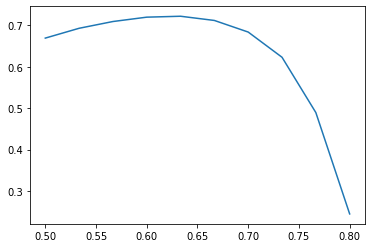

threshold:0.6333333333333333
dice score:0.7221328616142273


In [ ]:
# Plot and show best threshold, best score
plt.plot(threshold,np.array(total_dice_))
plt.show()

s = threshold[np.argmax(np.array(total_dice_))]
print("threshold:{}".format(s))
print("dice score:{}".format(np.max(np.array(total_dice_))))

### Training with **DICE** LOSS

In [ ]:
# Clear some gpu memory
torch.cuda.empty_cache()

In [ ]:
# Creating a folder where models will be saved
version = "14"
save_folder = "/content/drive/MyDrive/ESSEC_Google_Drive/Cours 4ième trimestre/Intro to Deep Learning/Kaggle Competition/models/Diceloss/UNET_2/models{}".format(version)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

print(save_folder)

/content/drive/MyDrive/ESSEC_Google_Drive/Cours 4ième trimestre/Intro to Deep Learning/Kaggle Competition/models/Diceloss/UNET_2/models14


#### Hyper-Parameters

In [ ]:
# UNET Model
model = UNet(in_channels=3, padding=True, n_classes=1,
             up_mode='upconv',wf=4, depth=6, batch_norm=True, drop=True).to(device)

# Optimizer
optim = torch.optim.Adam(model.parameters())

# Criterion
criterion = DiceLoss()
criterion.to(device)

# Others
epochs = 50

In [ ]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
              ReLU-2         [-1, 16, 256, 256]               0
       BatchNorm2d-3         [-1, 16, 256, 256]              32
            Conv2d-4         [-1, 16, 256, 256]           2,320
              ReLU-5         [-1, 16, 256, 256]               0
       BatchNorm2d-6         [-1, 16, 256, 256]              32
     UNetConvBlock-7         [-1, 16, 256, 256]               0
            Conv2d-8         [-1, 32, 128, 128]           4,640
              ReLU-9         [-1, 32, 128, 128]               0
      BatchNorm2d-10         [-1, 32, 128, 128]              64
           Conv2d-11         [-1, 32, 128, 128]           9,248
             ReLU-12         [-1, 32, 128, 128]               0
      BatchNorm2d-13         [-1, 32, 128, 128]              64
    UNetConvBlock-14         [-1, 32, 1

### *DICE Loss*: Training & Results

In [ ]:
train_loss, val_loss = training_unet(model, train_dataloader, val_dataloader, save_folder, device,
              optim, criterion, epochs, depth=6, wf=4, dice_loss=True, dropout=True)
 



Epoch n°1
- average TRAINING loss =  0.3471651646528351
- average VALIDATION loss =  0.20255029201507568




Epoch n°2
- average TRAINING loss =  0.2716326623150472
- average VALIDATION loss =  0.19901853799819946




Epoch n°3
- average TRAINING loss =  0.25595870496851675
- average VALIDATION loss =  0.187383234500885




Epoch n°4
- average TRAINING loss =  0.23639259629704978
- average VALIDATION loss =  0.1781688928604126




Epoch n°5
- average TRAINING loss =  0.21937804108255365
- average VALIDATION loss =  0.1535244584083557




Epoch n°6
- average TRAINING loss =  0.2064134224077289
- average VALIDATION loss =  0.18181121349334717




Epoch n°7
- average TRAINING loss =  0.20106378097212715
- average VALIDATION loss =  0.16121363639831543




Epoch n°8
- average TRAINING loss =  0.19678209470898916
- average VALIDATION loss =  0.14115756750106812




Epoch n°9
- average TRAINING loss =  0.18895666184050314
- average VALIDATION loss =  0.14608192443847656




Epoch n°10
- average TRAINING loss =  0.18640371638067652
- average VALIDATION loss =  0.14242547750473022




Epoch n°11
- average TRAINING loss =  0.1869936938701051
- average VALIDATION loss =  0.14848047494888306




Epoch n°12
- average TRAINING loss =  0.1827649822395839
- average VALIDATION loss =  0.1425914764404297




Epoch n°13
- average TRAINING loss =  0.18172426839892783
- average VALIDATION loss =  0.13041090965270996




Epoch n°14
- average TRAINING loss =  0.18158355572920168
- average VALIDATION loss =  0.14968407154083252




Epoch n°15
- average TRAINING loss =  0.17855965002868954
- average VALIDATION loss =  0.13044047355651855




Epoch n°16
- average TRAINING loss =  0.17529621134313306
- average VALIDATION loss =  0.157090425491333




Epoch n°17
- average TRAINING loss =  0.17550013256206942
- average VALIDATION loss =  0.15628576278686523




Epoch n°18
- average TRAINING loss =  0.17266525060273288
- average VALIDATION loss =  0.1301245093345642




Epoch n°19
- average TRAINING loss =  0.17315146929762337
- average VALIDATION loss =  0.1409338116645813




Epoch n°20
- average TRAINING loss =  0.17418222765574295
- average VALIDATION loss =  0.14976221323013306




Epoch n°21
- average TRAINING loss =  0.16914027008447755
- average VALIDATION loss =  0.1362646222114563




Epoch n°22
- average TRAINING loss =  0.16650680109356228
- average VALIDATION loss =  0.1351040005683899




Epoch n°23
- average TRAINING loss =  0.16665886660640158
- average VALIDATION loss =  0.14073985815048218




Epoch n°24
- average TRAINING loss =  0.16545233297883793
- average VALIDATION loss =  0.14124232530593872




Epoch n°25
- average TRAINING loss =  0.16550491030296582
- average VALIDATION loss =  0.17197346687316895




Epoch n°26
- average TRAINING loss =  0.16337374924273973
- average VALIDATION loss =  0.14769798517227173




Epoch n°27
- average TRAINING loss =  0.163853139020084
- average VALIDATION loss =  0.13642066717147827




Epoch n°28
- average TRAINING loss =  0.16403674844945415
- average VALIDATION loss =  0.13418954610824585




Epoch n°29
- average TRAINING loss =  0.16166049158305265
- average VALIDATION loss =  0.1411537528038025




Epoch n°30
- average TRAINING loss =  0.16234260462643055
- average VALIDATION loss =  0.15209072828292847




Epoch n°31
- average TRAINING loss =  0.1618987979848733
- average VALIDATION loss =  0.13777530193328857




Epoch n°32
- average TRAINING loss =  0.16166141193904235
- average VALIDATION loss =  0.1457371711730957




Epoch n°33
- average TRAINING loss =  0.16147707051105714
- average VALIDATION loss =  0.13987594842910767




Epoch n°34
- average TRAINING loss =  0.1594126924370112
- average VALIDATION loss =  0.14510482549667358




Epoch n°35
- average TRAINING loss =  0.15776277844155773
- average VALIDATION loss =  0.1442224383354187




Epoch n°36
- average TRAINING loss =  0.15650359164463
- average VALIDATION loss =  0.14217203855514526




Epoch n°37
- average TRAINING loss =  0.15824462774764286
- average VALIDATION loss =  0.148603618144989




Epoch n°38
- average TRAINING loss =  0.15671037020308248
- average VALIDATION loss =  0.14116865396499634




Epoch n°39
- average TRAINING loss =  0.15397243268704147
- average VALIDATION loss =  0.12940919399261475




Epoch n°40
- average TRAINING loss =  0.15425158082769158
- average VALIDATION loss =  0.1395525336265564




Epoch n°41
- average TRAINING loss =  0.15506641047724176
- average VALIDATION loss =  0.14088904857635498




Epoch n°42
- average TRAINING loss =  0.1549500036105681
- average VALIDATION loss =  0.17089641094207764




Epoch n°43
- average TRAINING loss =  0.1560393340801925
- average VALIDATION loss =  0.13930028676986694




Epoch n°44
- average TRAINING loss =  0.15405978865168068
- average VALIDATION loss =  0.13608318567276




Epoch n°45
- average TRAINING loss =  0.15465930422370353
- average VALIDATION loss =  0.1358492374420166




Epoch n°46
- average TRAINING loss =  0.15475973219014286
- average VALIDATION loss =  0.13617295026779175




Epoch n°47
- average TRAINING loss =  0.15317600027898723
- average VALIDATION loss =  0.15318036079406738




Epoch n°48
- average TRAINING loss =  0.151224809751082
- average VALIDATION loss =  0.13843309879302979




Epoch n°49
- average TRAINING loss =  0.1503364316533121
- average VALIDATION loss =  0.13390034437179565




Epoch n°50
- average TRAINING loss =  0.15127637044767314
- average VALIDATION loss =  0.14220595359802246



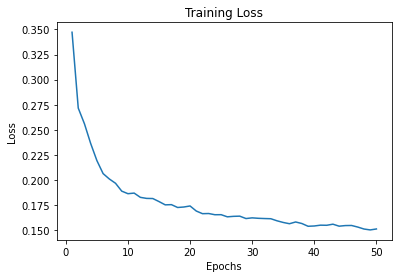

In [ ]:
# Training Curves
save_graph(train_loss, epochs, save_folder)

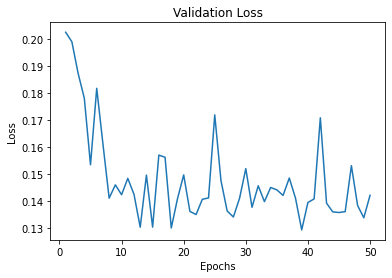

In [ ]:
# Validation Curves
save_graph(val_loss, epochs, save_folder, validation=True)

## 5 - Evaluation on the test set

In [ ]:
# We load the best model
model = UNet(in_channels=3, padding=True, n_classes=1,
             up_mode='upconv',wf=4, depth=6, batch_norm=True, drop=True).to(device)

nb = "39"
model_path = save_folder + "/UNET_epoch"+nb + ".pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
# Test
model.eval()
compute_dice(test_dataloader, model, 0.5)

0.90696967
0.897877
0.82869166
0.84474367
0.76773065
0.81272244
0.7996078
0.9041238
0.8287656
0.8594067
0.81389844
0.8567902
0.84899056
0.85711575
0.8899311
0.8878687
0.89651835
0.82249486
0.8937977
0.84670556
0.86999506
0.86210823
0.85206723
0.87508106
0.82039595
0.8494642
0.8260552
0.86177355
0.87646806
0.8314596
0.85647076
0.8726444
0.82301086
0.872598
0.8793118
0.8383004
0.83090407
0.7958825
0.83767134
0.7972041
0.8270764
0.7754405
0.87828004
0.86771417
0.8538174
0.88421756
0.8084208
0.88850904
0.83893275
0.83987874
0.7699418
0.8718203
0.8280773
0.8244982
0.8400708
0.8538881
0.8484207
0.8276959
0.81546867
0.8462934
0.8089707
0.8676584
0.78968763
0.7882939
0.87674886
0.8223239
0.8134488
0.82512003
0.88785654
0.84654546
0.86056906
0.81794405
0.8782687
0.85971856
0.8652701
0.8485307
0.84109783
0.81663144
0.7742902
0.8751754
0.7611817
0.83816814
0.8646352
0.86403686
0.8130004
0.7813933
0.8420694
0.846967
0.8530795
0.843989
0.81735015
0.84901613
0.76374024
0.84322995
0.8261594
0.8550604

0.842574

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


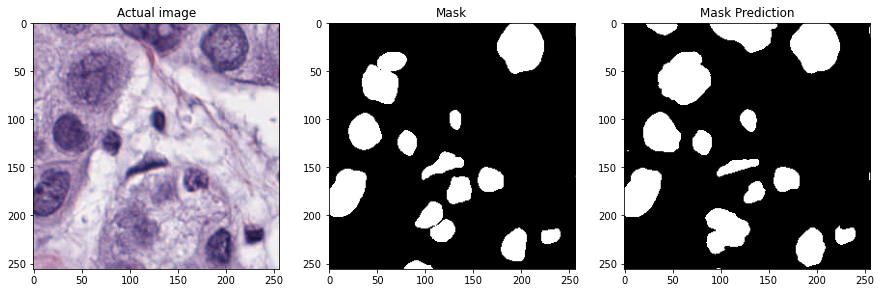

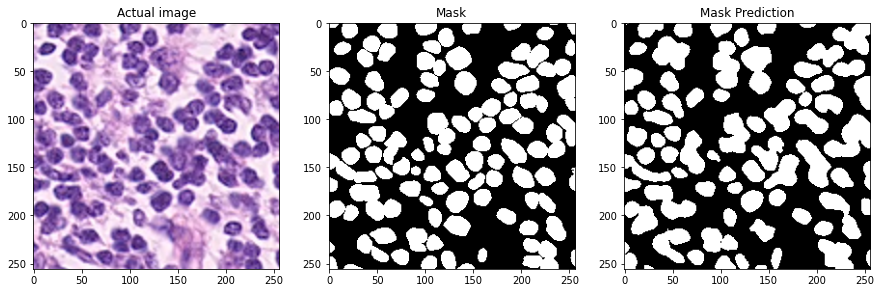

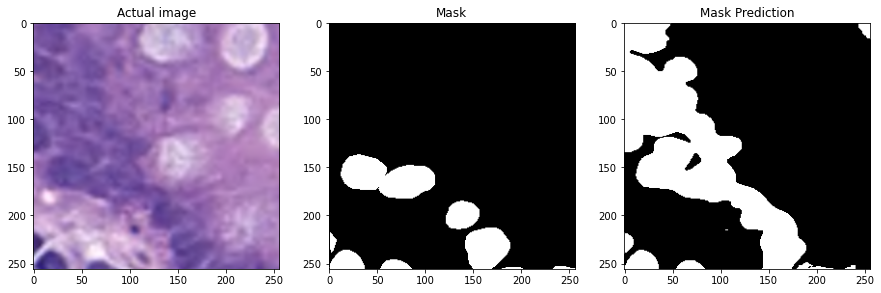

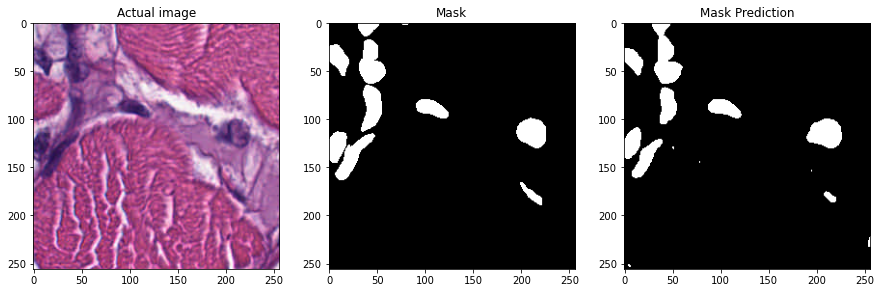

In [ ]:
show_all(test_dataset, 10, model, 0.5)
show_all(test_dataset, 12, model, 0.5)
show_all(test_dataset, 13, model, 0.1)
show_all(test_dataset, 19, model, 0.5)

Seeing which model performs best on the test set

In [ ]:
total_dice_ = []
nbr = np.arange(15, 51)
for nb in tqdm(nbr):
    # We load the best model
    unet_model = UNet(in_channels=3, padding=True, n_classes=1,up_mode='upconv',wf=4, depth=6, batch_norm=True, drop=True).to(device)
    path = save_folder + "/UNET_epoch"+ str(nb) + ".pt"
    unet_model.load_state_dict(torch.load(path)) 
    unet_model.eval()
    total_dice_.append(compute_dice(test_dataloader, unet_model, 0.5))

0.8842365
0.8909011
0.804695
0.8424541
0.7615233
0.7979549
0.7679494
0.89820284
0.80879563
0.8489274
0.8027649
0.81637686
0.8320402
0.85347134
0.87034875
0.869876
0.8798905
0.7915571
0.88022006
0.8373592
0.8571774
0.8533488
0.82036316
0.835811
0.8194992
0.8432243
0.8096097
0.8615585
0.8665243
0.82564884
0.8515929
0.8741691
0.8190777
0.81785727
0.86757123
0.8232593
0.81851006
0.8179662
0.80580235
0.7846744
0.8083762
0.7531519
0.8497925
0.8533568
0.81334245
0.8676425
0.804409
0.87214476
0.8426672
0.81625426
0.755741
0.86538637
0.80712616
0.6930045
0.8268268
0.8509566
0.8385027
0.82913023
0.8013109
0.8265971
0.7764494
0.8604896
0.7723671
0.77722263
0.86647356
0.79504645
0.79086083
0.8284695
0.8846933
0.8260213
0.8563508
0.7995061
0.86663836
0.8522901
0.8542921
0.84241676
0.82713497
0.77870244
0.76184213
0.86800337
0.782925
0.8174175
0.86502916
0.8527963
0.765275
0.7626161
0.8306691
0.8537696
0.84477496
0.8219606
0.8037073
0.8523419
0.76813596
0.8587917
0.8295808
0.8480407
0.78731006
0.836

0.8348875
0.86409295
0.8020311
0.6481616
0.73586935
0.81879365
0.7819537
0.8884597
0.8119168
0.8299024
0.7935729
0.6308347
0.8126405
0.85709083
0.8231724
0.87855244
0.86960435
0.77439547
0.8701862
0.7742505
0.86223316
0.85272026
0.83459
0.8602813
0.8073774
0.83646584
0.7650016
0.8601291
0.8710262
0.81549263
0.849464
0.8740683
0.80348474
0.8488964
0.86250466
0.84187233
0.7996948
0.7840596
0.8054169
0.7819159
0.7903802
0.74723995
0.8602283
0.84965664
0.8197264
0.8740255
0.7578517
0.86273104
0.8196166
0.7947139
0.6659952
0.84769636
0.80207366
0.80329996
0.81882524
0.8481359
0.83279943
0.81805813
0.7561734
0.8307065
0.78193355
0.86967754
0.6317751
0.7519904
0.8647237
0.7833666
0.8110906
0.7095591
0.8675837
0.8121846
0.83844703
0.7508785
0.86029917
0.85474676
0.8484687
0.83794206
0.8160741
0.7611973
0.74629277
0.85810775
0.55572546
0.8178152
0.84521174
0.8259737
0.8039927
0.7546682
0.83033633
0.8256592
0.83163506
0.8264377
0.8004277
0.8297711
0.6903357
0.8470153
0.8161676
0.8348558
0.796236

0.8814818
0.8796968
0.83397734
0.82971334
0.7715223
0.83427066
0.7672039
0.88754916
0.7983308
0.8326465
0.81484175
0.83669174
0.8404703
0.8548089
0.87292457
0.87696224
0.8690969
0.8065345
0.8864416
0.82832086
0.8447994
0.85883856
0.84445417
0.8718699
0.8129468
0.8396015
0.8091967
0.86641127
0.8773348
0.83884066
0.8637528
0.8814943
0.8426321
0.84862065
0.865005
0.83875406
0.82711524
0.78444797
0.82000613
0.78258574
0.78891766
0.7610437
0.8643376
0.85501033
0.84674335
0.8769006
0.74641734
0.87638676
0.8431298
0.8126979
0.75964904
0.8814408
0.826549
0.82144696
0.82662654
0.86068654
0.8545367
0.81542087
0.79746073
0.8264586
0.79972565
0.87179446
0.80709875
0.76970077
0.87502897
0.79750437
0.8094658
0.811939
0.8606753
0.8402579
0.8426767
0.7831852
0.8741236
0.83453643
0.86109537
0.8459799
0.83255726
0.7945161
0.7609799
0.8637872
0.754754
0.81547314
0.8553708
0.8490596
0.7924335
0.7795639
0.83294964
0.8415546
0.8600543
0.83658034
0.8086256
0.84367055
0.7552441
0.8689814
0.82199806
0.8299929


0.8902656
0.890955
0.8284172
0.8333899
0.75606805
0.8089541
0.74713635
0.8955062
0.8239723
0.8527747
0.7927966
0.8435118
0.85002947
0.86223257
0.87953156
0.88294756
0.8876925
0.8169654
0.8741964
0.8257091
0.86460054
0.84872097
0.84652716
0.86982995
0.7964336
0.8393451
0.8030249
0.86155987
0.8804627
0.8354246
0.8537625
0.8686584
0.82484263
0.8571156
0.86403626
0.84209865
0.8234518
0.7984257
0.82285905
0.78974026
0.8074915
0.76478046
0.8713629
0.8598189
0.84086514
0.87631696
0.81873196
0.87147576
0.8361053
0.8201151
0.7618719
0.8622066
0.8143293
0.7421513
0.8337112
0.8513312
0.8510363
0.8413477
0.78757787
0.8025002
0.80165184
0.8768759
0.7932602
0.7847186
0.87231755
0.77154744
0.8060273
0.8353696
0.8829253
0.8360312
0.84997493
0.7844003
0.8627828
0.8406714
0.85805726
0.83828366
0.8359368
0.81439656
0.74382156
0.865148
0.7868763
0.78893733
0.8554108
0.84610164
0.7940498
0.79722744
0.83283514
0.83380604
0.864
0.8501311
0.8038891
0.848063
0.78092057
0.86592495
0.83781284
0.84425306
0.847644

0.8854624
0.89065254
0.8291803
0.84063387
0.7585763
0.82935864
0.7893693
0.8920746
0.8006678
0.83407897
0.80819345
0.842156
0.8213181
0.85032123
0.8831669
0.8800658
0.8906119
0.8114687
0.87176514
0.83841985
0.8593813
0.8530508
0.8421188
0.8630211
0.8148771
0.8395451
0.8102023
0.8692444
0.8784317
0.83174837
0.8484639
0.8700338
0.82949024
0.8469994
0.8686802
0.8273569
0.8354038
0.7755999
0.82348305
0.77342594
0.812897
0.7743682
0.8758218
0.8574481
0.8329411
0.87860316
0.82011306
0.8769059
0.84352124
0.83233756
0.7746106
0.8706538
0.8171498
0.7997211
0.830054
0.8446782
0.8420595
0.8090687
0.80396307
0.8222937
0.80216223
0.8648006
0.79502136
0.7784129
0.8733347
0.80208814
0.81066453
0.8361998
0.88372886
0.8380613
0.85618204
0.7948555
0.87999445
0.86356735
0.85793424
0.8441172
0.8249787
0.7991
0.75888777
0.8721212
0.7786232
0.8345462
0.85705817
0.8437025
0.81563765
0.76429826
0.8248499
0.85870004
0.8541622
0.81436515
0.79896045
0.8509136
0.72320586
0.86507183
0.81747574
0.84864885
0.8260593

0.87448436
0.88869554
0.83090055
0.8340468
0.7680078
0.8374199
0.74540395
0.89266175
0.8087637
0.8435845
0.81155485
0.82513005
0.8471184
0.8593937
0.8845759
0.87776935
0.8838553
0.830572
0.86391443
0.84181446
0.8521179
0.8465417
0.8451616
0.8663822
0.8043684
0.84837455
0.79848987
0.85770804
0.88320863
0.8410593
0.86674523
0.885755
0.8391804
0.8585973
0.87217
0.82822794
0.80824584
0.8157462
0.8038569
0.8032842
0.8032371
0.76538527
0.85735637
0.8529458
0.84240294
0.8812244
0.79467314
0.8751684
0.84301656
0.8089073
0.7594566
0.8623915
0.8195656
0.83734787
0.82196754
0.8630105
0.8372161
0.8445132
0.7937611
0.8105871
0.80819654
0.8708847
0.811401
0.77195317
0.8712853
0.77435005
0.81411874
0.8318211
0.8712923
0.82967585
0.85468096
0.7995455
0.8731078
0.8489891
0.8701238
0.84747946
0.83799165
0.80488145
0.75362116
0.85811025
0.76865333
0.78835714
0.860372
0.86467135
0.7950635
0.7700673
0.83571553
0.83527666
0.86045194
0.8455023
0.81613135
0.8433861
0.792371
0.85962397
0.8348991
0.8407081
0.82

0.8966009
0.8915407
0.822685
0.83898795
0.734447
0.81421816
0.8041805
0.89665204
0.7746065
0.84643936
0.8053799
0.84920764
0.836221
0.8486907
0.8804406
0.88197577
0.88676625
0.80976224
0.8751345
0.83977383
0.8637444
0.86008406
0.8405378
0.86247486
0.8192474
0.8462308
0.81978065
0.85926217
0.87203455
0.82174665
0.8421574
0.8693229
0.82867783
0.84826297
0.8674348
0.81750274
0.82987106
0.7844765
0.8311491
0.7865164
0.7941895
0.7683127
0.8623236
0.8549126
0.8499937
0.8860709
0.8097475
0.8819621
0.83872104
0.8307109
0.75139904
0.86257035
0.8163175
0.79607266
0.8306478
0.8422277
0.8409916
0.8239328
0.80596435
0.8218271
0.7803421
0.8709639
0.7877739
0.7759843
0.87337196
0.8045384
0.8062306
0.8319507
0.8883087
0.84545314
0.84552264
0.8039277
0.8769409
0.8547453
0.8579327
0.8374648
0.8402079
0.791526
0.7605336
0.862293
0.7651995
0.8046633
0.8640064
0.8374521
0.7975277
0.76906896
0.8358966
0.8582087
0.849495
0.83014023
0.80590147
0.8532685
0.77289635
0.8571579
0.82931215
0.8530252
0.8341216
0.84

0.88791835
0.8950045
0.83463985
0.8415999
0.8013958
0.82306147
0.7665686
0.89743084
0.8151456
0.8373415
0.8054786
0.8393768
0.8602199
0.8600009
0.8861818
0.88643014
0.8861462
0.8252446
0.8857368
0.8418389
0.87236834
0.8578694
0.8537472
0.8561265
0.8207053
0.85117596
0.8037295
0.86748344
0.87372863
0.8386277
0.8506427
0.8762367
0.84322196
0.8592505
0.8764226
0.8333675
0.83244807
0.8171434
0.8211521
0.7930026
0.80485845
0.7587214
0.8569491
0.86130506
0.8303836
0.8775851
0.759017
0.88372916
0.84452915
0.82343775
0.7710374
0.8775953
0.81906056
0.8452145
0.83417135
0.8648717
0.8399593
0.8411207
0.8015573
0.8011777
0.8051914
0.87715304
0.8047865
0.7752746
0.8758913
0.7974131
0.7942993
0.84567344
0.88914937
0.82766396
0.85309047
0.80502003
0.87674505
0.85204726
0.87024885
0.84399545
0.8444234
0.8042473
0.7644999
0.8658728
0.74499494
0.7692908
0.8602797
0.88311195
0.8037416
0.7908741
0.8491097
0.8458822
0.8539494
0.8537481
0.8013964
0.8359605
0.82027614
0.8747944
0.8229742
0.8231277
0.8204569


0.90068126
0.89522386
0.83743656
0.8378922
0.75776887
0.8103012
0.78835416
0.897796
0.7902184
0.8534204
0.81345195
0.8400937
0.8364929
0.8590522
0.87454855
0.8846088
0.8877671
0.80671287
0.875693
0.82927954
0.8606698
0.8589634
0.84207004
0.8620423
0.82799464
0.8588222
0.81985676
0.86571693
0.88195103
0.81923974
0.82847667
0.8739953
0.831224
0.8492511
0.8633072
0.83572054
0.8332926
0.8023233
0.8325494
0.8057484
0.7926413
0.7722208
0.865126
0.860603
0.8467982
0.87649477
0.82539725
0.87736964
0.84331936
0.8274841
0.77856636
0.86954695
0.81708705
0.82366616
0.8234533
0.8444897
0.83952993
0.82085574
0.7938967
0.8293243
0.80903
0.8728199
0.7958382
0.7681793
0.8745465
0.80899674
0.8093436
0.822017
0.87796766
0.8428392
0.8516394
0.7979723
0.8782742
0.84556156
0.84831876
0.843592
0.83939666
0.8336565
0.7508963
0.84945047
0.72461396
0.80988884
0.8616359
0.8565863
0.801141
0.7571642
0.8235906
0.8442898
0.8671287
0.8233624
0.78636867
0.8473947
0.72268754
0.869712
0.85051376
0.83742225
0.8359688
0.

0.8808515
0.8833653
0.8168338
0.8449834
0.7489432
0.7914179
0.78093886
0.8934884
0.8147483
0.8504177
0.79365593
0.8399861
0.8220882
0.8439683
0.87457305
0.8678087
0.8826649
0.79479027
0.85501546
0.8254189
0.8635297
0.85210145
0.8361793
0.8479573
0.8187422
0.8426411
0.8099698
0.8614094
0.868071
0.804628
0.8164898
0.84579724
0.80594
0.83800226
0.8739261
0.83157516
0.824973
0.7842091
0.8241846
0.7861292
0.80691016
0.7603976
0.8501061
0.8500771
0.8318425
0.8765222
0.7924419
0.8790224
0.84254444
0.82491124
0.7631007
0.86572766
0.8010441
0.80056953
0.80735993
0.8184085
0.8270878
0.8169999
0.7965975
0.81308097
0.76381207
0.8651689
0.7779576
0.7584278
0.85913396
0.79496557
0.7705896
0.80865955
0.8899029
0.823269
0.8480008
0.8069776
0.86897683
0.84342587
0.8350336
0.8189453
0.8146847
0.79003805
0.77323246
0.86426836
0.74614644
0.8154589
0.8564601
0.8355214
0.78161174
0.76706135
0.81417286
0.8517326
0.85010237
0.8221666
0.788634
0.84058577
0.77282304
0.8496371
0.834642
0.8450492
0.8136793
0.8310

0.84352213
0.8704264
0.7950826
0.8125107
0.75514144
0.80779886
0.70816123
0.8852638
0.7986203
0.7954479
0.79851854
0.7809333
0.8299896
0.7892609
0.79931974
0.8444389
0.8873633
0.786762
0.7772693
0.73465407
0.8570373
0.7831624
0.7756246
0.83553725
0.78423136
0.8353219
0.73929393
0.84513295
0.82725674
0.8245084
0.69403297
0.8444629
0.7969413
0.80419797
0.8432596
0.81177706
0.8047656
0.8157558
0.8254925
0.7962694
0.79768217
0.711242
0.78098667
0.82602316
0.7673483
0.8338875
0.7508694
0.85400033
0.823619
0.7989339
0.7401442
0.8441124
0.768989
0.7089233
0.80267197
0.8435251
0.79476947
0.8328506
0.70020443
0.72400886
0.74821025
0.81766886
0.8096837
0.65898645
0.84837085
0.7572104
0.7451979
0.8039093
0.8688481
0.77336025
0.84196824
0.8194803
0.7883799
0.7387908
0.84905994
0.8061801
0.8102558
0.76838475
0.73616076
0.848606
0.7177931
0.81812197
0.8106472
0.85123837
0.783613
0.72660595
0.78133315
0.7798652
0.8179112
0.7057426
0.71693873
0.7751055
0.79996586
0.858128
0.8346224
0.69643986
0.761110

0.8858424
0.8881338
0.81814516
0.85842776
0.7780928
0.8116012
0.7678241
0.8933282
0.8333132
0.8543835
0.8026155
0.8425122
0.8434506
0.8587259
0.8817282
0.8704207
0.8948188
0.8044065
0.8752525
0.8371579
0.8619987
0.85538536
0.8300142
0.8538347
0.81493115
0.8611226
0.8130382
0.8711482
0.8674585
0.82111067
0.8533538
0.88303685
0.83927256
0.8485838
0.87805754
0.8249421
0.8332452
0.805536
0.8341069
0.8076855
0.81755394
0.7694397
0.855319
0.85667676
0.8457125
0.87601143
0.80864835
0.87415445
0.8576047
0.82983404
0.77061945
0.8677587
0.82284725
0.8020152
0.8354806
0.8474024
0.8514087
0.8259219
0.78206
0.82743645
0.7892461
0.86393553
0.800572
0.7679764
0.8745022
0.79051906
0.79426265
0.83802754
0.88703233
0.805196
0.8385747
0.81624115
0.87787926
0.8471185
0.8759221
0.8455181
0.83030874
0.79990965
0.758688
0.87301093
0.7303501
0.83151466
0.8632514
0.8327417
0.8162963
0.76292443
0.8316204
0.8230768
0.84192634
0.8425816
0.82005703
0.85064983
0.7085494
0.8615636
0.83685493
0.827708
0.7850418
0.835

0.8791433
0.88352567
0.8244779
0.8508887
0.77620894
0.8167785
0.7876409
0.89210117
0.81860226
0.848758
0.8020908
0.8388395
0.83946806
0.86625534
0.8733703
0.8711293
0.8928913
0.80318165
0.88067305
0.8439996
0.8674569
0.84821457
0.821844
0.8681753
0.81901175
0.8631672
0.819628
0.8762282
0.87369406
0.8347381
0.84047914
0.8759376
0.8403913
0.8091066
0.8721562
0.8356105
0.8330386
0.8262245
0.82446635
0.79835236
0.81626475
0.76311404
0.8481896
0.85339427
0.8387356
0.87306637
0.8130309
0.88044095
0.8243112
0.8314695
0.7545086
0.87733394
0.81341016
0.80298156
0.83973914
0.8482214
0.84008145
0.8421929
0.78219676
0.8464335
0.78664005
0.87004834
0.809113
0.7861201
0.8678504
0.8166417
0.79318213
0.82756895
0.8916365
0.8157511
0.86059964
0.81475204
0.8720128
0.82436246
0.8710215
0.8537525
0.8427605
0.7887152
0.7621693
0.865833
0.79085934
0.8297979
0.85378486
0.8619416
0.81387633
0.78798324
0.83757955
0.82511634
0.84364265
0.8564275
0.81659746
0.8307989
0.82081497
0.860958
0.83891183
0.81862867
0.8

0.88168854
0.88590074
0.82696086
0.84574133
0.7628478
0.81147635
0.7884718
0.89452827
0.824319
0.8499105
0.7990379
0.84151185
0.85479283
0.8629132
0.8828427
0.8732408
0.89437187
0.8020836
0.8826408
0.8503021
0.86510354
0.8528222
0.83437437
0.863797
0.8231491
0.8613678
0.8250572
0.86773604
0.877187
0.8238078
0.8506685
0.8631265
0.8311806
0.8530918
0.8815104
0.83413374
0.83332515
0.8319174
0.8238156
0.80939305
0.80376047
0.7586234
0.8616903
0.8537311
0.850588
0.8784153
0.8032757
0.88214874
0.8329609
0.83396935
0.75636816
0.8656419
0.8326914
0.84090173
0.84285825
0.84711194
0.8466651
0.8427217
0.8020938
0.84581584
0.7876929
0.8682477
0.7961937
0.78375804
0.8657048
0.80222225
0.78453076
0.83921564
0.8880853
0.8392704
0.8654453
0.81882644
0.87428695
0.8333834
0.86744297
0.8342545
0.84391195
0.7988752
0.77571166
0.87216544
0.74786747
0.82077515
0.8584106
0.8639377
0.80135566
0.77127665
0.8519199
0.83828056
0.8457964
0.8538565
0.81376624
0.84681034
0.8240618
0.861683
0.85000056
0.84073603
0.8

0.89799774
0.8988104
0.83334035
0.8555831
0.7425954
0.81687057
0.79275525
0.9016285
0.80350035
0.85406756
0.8072521
0.8519595
0.83685434
0.8510815
0.88862497
0.87909764
0.8961666
0.81212425
0.8783023
0.8448388
0.87138
0.8588223
0.85361385
0.8650531
0.82292557
0.8544409
0.8228518
0.87866336
0.8737368
0.8401986
0.8439192
0.87584466
0.82375765
0.8685428
0.8681425
0.822858
0.82466364
0.7864079
0.8417992
0.8017163
0.8123675
0.77925706
0.8647783
0.8551533
0.84995097
0.88047814
0.8098247
0.89460135
0.8425435
0.8352373
0.7576098
0.8756316
0.8160302
0.8015643
0.82657856
0.8532377
0.84798396
0.81865156
0.80328715
0.8210973
0.78319746
0.8705798
0.7995927
0.7794385
0.8756506
0.8111347
0.80851567
0.83626926
0.88772243
0.837692
0.8620123
0.8045174
0.881399
0.8624553
0.8665807
0.84549904
0.83757824
0.81692994
0.7730383
0.8671551
0.77877384
0.8112724
0.86059445
0.8556785
0.81300485
0.7562083
0.8360439
0.86235744
0.86108804
0.8225573
0.79395646
0.8541039
0.71338516
0.85673094
0.85005337
0.85070556
0.82

0.8844377
0.88298416
0.82896096
0.86338073
0.74151796
0.8182588
0.79946315
0.8935647
0.82428217
0.84797895
0.8120151
0.8460729
0.8292039
0.8470271
0.88575923
0.86941284
0.8855861
0.8119886
0.88339335
0.8514475
0.86660933
0.85836494
0.8427953
0.8637242
0.8153413
0.83492076
0.8189244
0.86063766
0.87864876
0.841318
0.851437
0.87779707
0.84147316
0.8691904
0.8666811
0.820113
0.8233463
0.8159894
0.8302423
0.79806316
0.8209314
0.77059025
0.8660114
0.852052
0.836873
0.8797981
0.7575247
0.88443774
0.8392037
0.8315049
0.75051814
0.8741374
0.8168033
0.7588141
0.82861096
0.8598353
0.85380256
0.83492327
0.80835205
0.8403141
0.8097087
0.8652306
0.8023231
0.7714985
0.876278
0.8085005
0.8127257
0.83051044
0.8840008
0.83399266
0.847674
0.815027
0.8738875
0.86571157
0.869985
0.84128326
0.8369327
0.78969246
0.7826505
0.8747118
0.7907593
0.8260828
0.8620379
0.8634963
0.8076275
0.77315587
0.83585125
0.8432996
0.8519366
0.8319893
0.8088702
0.84419835
0.74020684
0.8670608
0.83034784
0.85422736
0.7921855
0.8

0.8928243
0.90062606
0.8350035
0.841044
0.7829099
0.8318106
0.7975803
0.89760566
0.8103002
0.86037284
0.81554127
0.8425161
0.8490162
0.85468036
0.8851996
0.8828738
0.89054924
0.8269512
0.8824975
0.8462496
0.87112635
0.8623097
0.8557591
0.86500895
0.8209186
0.84270483
0.8151574
0.8762859
0.87562346
0.8301808
0.85607404
0.8747329
0.8415193
0.8518659
0.8714595
0.8367389
0.84203106
0.7956229
0.83461624
0.8145618
0.8152278
0.768488
0.86878127
0.86404026
0.8411588
0.8802976
0.83330804
0.88282466
0.84482706
0.84002256
0.7682959
0.8771877
0.83770216
0.8340871
0.8294848
0.85494244
0.8604944
0.8280454
0.80058783
0.83385867
0.8118122
0.87486374
0.79752535
0.77626634
0.87827575
0.8234696
0.81930095
0.8346679
0.8815501
0.84326744
0.86036813
0.81252587
0.8817406
0.8580109
0.87096334
0.8439063
0.8454108
0.8038021
0.7711517
0.8656656
0.77656126
0.8239201
0.86073875
0.8637708
0.8017655
0.75545025
0.8348462
0.85559344
0.85671735
0.83044285
0.8058799
0.8460036
0.6982508
0.8639696
0.83962774
0.85136396
0.

0.89284235
0.8871779
0.84245074
0.8322205
0.7873658
0.8246793
0.8017227
0.90062684
0.82362807
0.85006046
0.8145901
0.8379855
0.8547692
0.862113
0.881893
0.8849688
0.89449227
0.82344157
0.8883358
0.8460569
0.87065065
0.8644375
0.85195595
0.8675116
0.82203335
0.8608815
0.82205117
0.8679517
0.88330376
0.83571583
0.86580724
0.88105214
0.8324105
0.8501205
0.87520117
0.8378621
0.8282881
0.8080067
0.8278471
0.8017381
0.81884533
0.77210027
0.86304885
0.8690617
0.86056495
0.88665444
0.8048672
0.886827
0.83963686
0.8255666
0.7677974
0.8724226
0.82360494
0.81905496
0.83780867
0.85887694
0.8550583
0.8516722
0.80407786
0.84427994
0.8000201
0.8766846
0.81589496
0.7786136
0.8811609
0.8111558
0.80724657
0.8261907
0.8876314
0.83383626
0.8639079
0.8124989
0.87938184
0.86151445
0.86821777
0.8450737
0.8445034
0.8142223
0.7705662
0.85692155
0.7767537
0.8202813
0.86649156
0.8709129
0.80587006
0.794846
0.8368828
0.83904666
0.84461325
0.84368414
0.8004983
0.8444699
0.8103223
0.8680293
0.8351701
0.8465068
0.84

0.8916267
0.8965697
0.83792406
0.8454599
0.80074304
0.819192
0.7979037
0.9025523
0.8264016
0.8615614
0.81205446
0.8541656
0.83869606
0.8605649
0.8837009
0.8797155
0.895297
0.8273284
0.8875454
0.8473401
0.864492
0.8606885
0.84873456
0.8732093
0.8233079
0.85516167
0.8097802
0.870663
0.882427
0.8457923
0.8518326
0.87737864
0.8436571
0.85643315
0.8782753
0.8391999
0.8307597
0.8161188
0.83411926
0.81417465
0.81180245
0.7716091
0.8744972
0.86303794
0.8627633
0.88486356
0.81883955
0.88544846
0.83871067
0.83415043
0.7799354
0.8711845
0.8439883
0.8346748
0.8324179
0.84524584
0.84305596
0.84306896
0.7903236
0.83497256
0.8121788
0.8748403
0.8035678
0.7867556
0.87353235
0.82103527
0.81514025
0.83945733
0.8861267
0.82372284
0.86243814
0.82899094
0.87181205
0.85919243
0.8618399
0.8535135
0.8357082
0.8258343
0.76777375
0.86203015
0.7703183
0.81878865
0.86132187
0.8701566
0.8021553
0.7697688
0.8382994
0.8439238
0.8604523
0.85183036
0.80358976
0.8391714
0.7060427
0.8610675
0.85334754
0.8517235
0.832725

0.8782655
0.90044874
0.83844626
0.8541692
0.803634
0.8311862
0.77326053
0.8932826
0.83331925
0.86325556
0.81988335
0.8431143
0.8444665
0.8599116
0.88887507
0.879675
0.89559454
0.8287756
0.89656985
0.8477713
0.8682258
0.8604964
0.84248763
0.8652653
0.8191314
0.8559043
0.81473005
0.872302
0.8852209
0.84033245
0.8680918
0.8774136
0.8451454
0.850997
0.8784633
0.8304716
0.8390452
0.8097469
0.8337528
0.8159842
0.81552756
0.7578179
0.86772305
0.85755146
0.8639823
0.8896869
0.8189651
0.88938737
0.8402703
0.8277512
0.76292396
0.87680894
0.8323832
0.8302463
0.8391009
0.8551178
0.84788555
0.8386871
0.81440043
0.85273033
0.809137
0.8705359
0.80898905
0.7840279
0.8765897
0.8039554
0.8257928
0.8461474
0.8696408
0.83116174
0.85140014
0.8289746
0.88399625
0.8484575
0.8785718
0.84613496
0.85024583
0.82299536
0.7670768
0.8640535
0.73952854
0.8392544
0.8511864
0.8681698
0.7932149
0.789238
0.84124684
0.8379377
0.8543093
0.85365677
0.8200236
0.8393723
0.7706045
0.8611262
0.84818685
0.8262348
0.8418746
0.83

0.8793809
0.88047945
0.8292254
0.85257125
0.78722113
0.81652236
0.78378135
0.90185446
0.83855367
0.85341775
0.8121453
0.8480522
0.8449926
0.86028975
0.892827
0.8747458
0.8895722
0.81111467
0.8880397
0.8472114
0.86962354
0.8543479
0.8319537
0.8528978
0.8319463
0.8491683
0.8260762
0.8497415
0.8756307
0.82629085
0.86486727
0.85856086
0.8151307
0.8547225
0.8760371
0.8409157
0.8299561
0.8194858
0.83005476
0.8011653
0.8131892
0.7787784
0.86463326
0.86134577
0.845873
0.8890097
0.8377273
0.8741895
0.8370953
0.83322924
0.76437145
0.8624547
0.8242409
0.8354164
0.84138453
0.85582095
0.8502596
0.836314
0.8060338
0.84961754
0.77160436
0.8706669
0.77547854
0.76472634
0.8715254
0.7876466
0.8180276
0.8418094
0.88500565
0.8416056
0.8553038
0.81485265
0.8767897
0.8486818
0.86858565
0.82550555
0.8348085
0.81839204
0.780045
0.8668758
0.7948742
0.8272469
0.8696279
0.8617569
0.7945779
0.7751678
0.84022695
0.8432247
0.84230506
0.8571165
0.82365954
0.8489791
0.7828598
0.8616909
0.8398904
0.8463869
0.8404672
0

0.89111954
0.89170974
0.82745796
0.837238
0.8086919
0.8355429
0.7364755
0.891687
0.8021758
0.8284368
0.8079463
0.8145274
0.85168374
0.86254215
0.8757141
0.8712514
0.8828039
0.81203485
0.88559365
0.833282
0.8583119
0.85161096
0.8510362
0.8736802
0.8062365
0.85415536
0.786463
0.8632793
0.87572163
0.8550283
0.8613381
0.8842913
0.83782804
0.85868007
0.85841787
0.8367179
0.80975205
0.7871723
0.828548
0.7923557
0.8099508
0.7569288
0.86434305
0.8429899
0.84944403
0.8720822
0.81265146
0.8700617
0.83651793
0.82103455
0.76985234
0.86659235
0.81791425
0.81438303
0.8447998
0.86347836
0.8386683
0.8145488
0.81071645
0.81147575
0.8021103
0.8647317
0.80894065
0.7780468
0.8755689
0.7935567
0.8113361
0.8332008
0.8681909
0.82779425
0.84765184
0.8174039
0.86976314
0.84506667
0.87201905
0.85594726
0.8267422
0.7919154
0.7633749
0.87390083
0.7432494
0.82115567
0.84782916
0.8783302
0.7940009
0.7825093
0.83420014
0.8365574
0.8557125
0.8579732
0.8001701
0.84563494
0.82325035
0.8607653
0.82525146
0.8384972
0.820

0.8841972
0.9001368
0.8408184
0.84912735
0.7599242
0.82197815
0.77715117
0.89197564
0.80373514
0.85123503
0.7920792
0.83041704
0.83830976
0.8580748
0.8735718
0.8779612
0.88956565
0.80836225
0.8841619
0.8450185
0.8649514
0.849608
0.8426705
0.86226666
0.8106852
0.85781413
0.806755
0.8681241
0.8726672
0.8375191
0.8403721
0.87182635
0.83084524
0.8431649
0.87398386
0.84225184
0.8302497
0.7989732
0.8341854
0.807867
0.8288901
0.76474375
0.85312694
0.85388696
0.85081804
0.8846652
0.81391186
0.8770744
0.8411107
0.8328542
0.7762394
0.8724519
0.8133797
0.8132785
0.8333829
0.8506148
0.8343206
0.8495794
0.7833173
0.8026772
0.8073632
0.8663374
0.79896986
0.76274604
0.87045974
0.80680907
0.8138203
0.8476066
0.87836415
0.8303277
0.8607725
0.8111356
0.8783975
0.85383314
0.8620586
0.855154
0.8416335
0.81573516
0.7699247
0.86579233
0.7771611
0.8070514
0.8638132
0.8593046
0.79578847
0.7403773
0.8206702
0.8522493
0.8472268
0.82114106
0.80288905
0.85039765
0.68965864
0.85648847
0.8439891
0.8434908
0.8287439

0.89786047
0.90045726
0.8434744
0.84142274
0.7769128
0.8279871
0.79807055
0.89529365
0.8196656
0.8518457
0.8166668
0.84998
0.85053325
0.8505008
0.88184065
0.8845956
0.88740647
0.82143545
0.89150506
0.83188534
0.8547496
0.8609661
0.8462321
0.8668004
0.81898487
0.8558909
0.8117348
0.87321514
0.8769925
0.83431095
0.8579417
0.8734255
0.8294092
0.85475063
0.8699512
0.8410185
0.82296425
0.78196716
0.830137
0.80893517
0.808824
0.7717513
0.8770113
0.861356
0.84009296
0.8818207
0.8189729
0.8861295
0.84415096
0.8354243
0.776566
0.88108784
0.83878505
0.8283483
0.83806795
0.8536097
0.84997743
0.8291877
0.8052861
0.8313873
0.8004987
0.86901194
0.8043543
0.78862965
0.87113774
0.8146353
0.81142867
0.8274042
0.8723423
0.85256046
0.86331517
0.8102017
0.88165784
0.85291415
0.863717
0.8505499
0.82782346
0.8010808
0.77053225
0.87173057
0.7431295
0.8256732
0.8652457
0.8647021
0.8068703
0.75734216
0.8282092
0.85508615
0.8545365
0.82730055
0.8108688
0.8433184
0.7429867
0.86436474
0.8359321
0.86151713
0.83791

0.90696967
0.897877
0.82869166
0.84474367
0.76773065
0.81272244
0.7996078
0.9041238
0.8287656
0.8594067
0.81389844
0.8567902
0.84899056
0.85711575
0.8899311
0.8878687
0.89651835
0.82249486
0.8937977
0.84670556
0.86999506
0.86210823
0.85206723
0.87508106
0.82039595
0.8494642
0.8260552
0.86177355
0.87646806
0.8314596
0.85647076
0.8726444
0.82301086
0.872598
0.8793118
0.8383004
0.83090407
0.7958825
0.83767134
0.7972041
0.8270764
0.7754405
0.87828004
0.86771417
0.8538174
0.88421756
0.8084208
0.88850904
0.83893275
0.83987874
0.7699418
0.8718203
0.8280773
0.8244982
0.8400708
0.8538881
0.8484207
0.8276959
0.81546867
0.8462934
0.8089707
0.8676584
0.78968763
0.7882939
0.87674886
0.8223239
0.8134488
0.82512003
0.88785654
0.84654546
0.86056906
0.81794405
0.8782687
0.85971856
0.8652701
0.8485307
0.84109783
0.81663144
0.7742902
0.8751754
0.7611817
0.83816814
0.8646352
0.86403686
0.8130004
0.7813933
0.8420694
0.846967
0.8530795
0.843989
0.81735015
0.84901613
0.76374024
0.84322995
0.8261594
0.8550604

0.8903541
0.89454573
0.8293317
0.82467264
0.7795602
0.82659346
0.8104431
0.8999284
0.82717615
0.8513633
0.80086315
0.82180965
0.85051817
0.86950296
0.877935
0.8782721
0.893871
0.8220678
0.8813413
0.8492134
0.87287337
0.84316945
0.8448935
0.86310923
0.8268496
0.85482585
0.8111366
0.8671528
0.88411736
0.835676
0.85461354
0.8812645
0.8248115
0.8619837
0.8804698
0.82957554
0.83353144
0.8134556
0.82334834
0.8072635
0.823169
0.76610357
0.8607545
0.85587466
0.85831153
0.87777716
0.8211984
0.8890416
0.8305263
0.829932
0.7841898
0.8755332
0.8339083
0.8334045
0.83377236
0.8512287
0.84025306
0.85568196
0.7905633
0.8535828
0.80836
0.8751245
0.7916334
0.7812489
0.87858295
0.80495733
0.79411256
0.84068424
0.8866674
0.83277005
0.8586461
0.81041825
0.8741571
0.838529
0.86181206
0.84873974
0.8383577
0.80431616
0.7597201
0.8661554
0.7589712
0.83084315
0.8428206
0.85823876
0.81381375
0.7931087
0.8519373
0.82633483
0.8458794
0.8488075
0.80828124
0.8422215
0.830563
0.85909766
0.84507626
0.82611585
0.840654

0.89202946
0.8914982
0.8380031
0.85184735
0.778091
0.82223547
0.7986858
0.90425396
0.8302795
0.83844054
0.8215019
0.84972686
0.847954
0.8680165
0.89636934
0.8882232
0.88961047
0.8134387
0.8786901
0.8451043
0.8696285
0.8557808
0.8533996
0.87819415
0.8192996
0.86633366
0.79294235
0.8682345
0.8827775
0.8538905
0.86504346
0.87751657
0.8396503
0.8610813
0.87249774
0.81031317
0.82871956
0.80292404
0.8399474
0.7844606
0.82003343
0.7731565
0.861084
0.868535
0.86336935
0.8871182
0.7516885
0.8876445
0.8234937
0.8411287
0.7631051
0.87720615
0.83647555
0.8379428
0.8433138
0.85950047
0.83586985
0.8502536
0.8058188
0.8429344
0.79944646
0.87155545
0.80349314
0.78382635
0.8754746
0.8142344
0.79113114
0.83275276
0.8729756
0.8385037
0.85742295
0.8275173
0.8854914
0.85679674
0.8643128
0.8486611
0.83391947
0.8064744
0.7605881
0.87500787
0.77924013
0.8145827
0.8586785
0.87810004
0.81191987
0.79089975
0.83897185
0.8313452
0.85711247
0.8523032
0.7932997
0.8424498
0.834903
0.8688401
0.83045787
0.82850885
0.83

0.87423927
0.87511325
0.83617705
0.81782246
0.79637724
0.83853215
0.71349484
0.8919288
0.80827796
0.83942896
0.801136
0.81493515
0.84503645
0.8606725
0.8538625
0.8821892
0.8574661
0.82277715
0.87897074
0.83064604
0.8417145
0.83498245
0.84858936
0.8555358
0.77921486
0.8355511
0.7733697
0.84658104
0.8541004
0.8419412
0.8569953
0.8701416
0.8185547
0.8561347
0.84658
0.82151026
0.8073047
0.72142255
0.8227008
0.7980382
0.8019035
0.76023185
0.873035
0.8516067
0.84189343
0.8822532
0.66752154
0.86188483
0.82043374
0.8085
0.7088134
0.85635453
0.8131759
0.84667164
0.83889306
0.8600188
0.8247151
0.84048307
0.7808135
0.7617234
0.79592115
0.880359
0.806887
0.79258025
0.8661927
0.7570132
0.81712145
0.8186097
0.86168325
0.82081926
0.85434836
0.774654
0.8799954
0.8215853
0.85120404
0.8508702
0.8274663
0.7813237
0.7647782
0.84914833
0.724797
0.78312105
0.8456651
0.8673435
0.75992346
0.7971114
0.82605296
0.8345931
0.8668111
0.84348506
0.7929503
0.82360584
0.80675006
0.8398687
0.83661276
0.8282125
0.83814

0.8947399
0.9003093
0.83672106
0.84454644
0.7759709
0.820403
0.7898833
0.8832019
0.8356988
0.8533008
0.8120149
0.8152107
0.8526474
0.8711482
0.87722737
0.8879228
0.89909345
0.82903004
0.8876996
0.83892465
0.86955297
0.85322136
0.8428793
0.87195444
0.8078516
0.8615978
0.7881821
0.86488885
0.87894523
0.8444953
0.8193472
0.8841491
0.8424897
0.85153645
0.86973464
0.8205964
0.8320445
0.8106987
0.8296901
0.8260611
0.79975086
0.7528443
0.86484385
0.85961205
0.8718109
0.88758713
0.8207414
0.86373615
0.8355838
0.8260981
0.77067816
0.8663559
0.84402055
0.8503459
0.8462128
0.8485192
0.8437105
0.85243124
0.7890064
0.84466857
0.806446
0.8712567
0.81341314
0.78767425
0.87332934
0.8157248
0.8173462
0.8387748
0.88435113
0.81723005
0.85776603
0.8335476
0.8862104
0.8585812
0.86826646
0.85770553
0.8321206
0.82589555
0.7562146
0.8742289
0.73858744
0.81521696
0.85796094
0.8583358
0.80222994
0.79314977
0.8162011
0.8256668
0.8536122
0.85403055
0.7805787
0.82675815
0.81894803
0.85205895
0.85681635
0.81985873


0.8954545
0.90270776
0.83626425
0.8557415
0.8061305
0.8040787
0.7964538
0.8963033
0.8301683
0.8644845
0.8131944
0.85092926
0.8465617
0.86656344
0.89194524
0.87928754
0.894763
0.811107
0.8842625
0.843426
0.86793685
0.8569263
0.8525615
0.86487126
0.8235412
0.85364825
0.8133956
0.86966187
0.87654185
0.82870114
0.823235
0.87402177
0.83653164
0.856988
0.8856025
0.82158136
0.837344
0.80803496
0.83579373
0.8110756
0.80927444
0.77762085
0.86703503
0.8598156
0.85917413
0.8874273
0.7731305
0.8805157
0.83729136
0.84171003
0.7547679
0.8812912
0.8106608
0.82591915
0.8386029
0.8441585
0.83606666
0.84383893
0.81283057
0.8461362
0.7926463
0.88222045
0.79823524
0.763556
0.8721891
0.8170421
0.8121603
0.8280495
0.8910736
0.83057857
0.8598951
0.83601165
0.88240606
0.8705672
0.866385
0.8464752
0.8441794
0.830254
0.77662945
0.8729286
0.7692222
0.8161664
0.8658561
0.86604416
0.80033463
0.78800035
0.82844543
0.83852315
0.8463132
0.84095263
0.7888924
0.83673126
0.81911486
0.85968107
0.85220414
0.8538449
0.8274

0.8941061
0.90193444
0.84548515
0.8590928
0.80531037
0.8267713
0.80345476
0.9019338
0.82767236
0.86316097
0.8191436
0.8433373
0.8482944
0.8739858
0.88962394
0.8881791
0.90008754
0.8276942
0.8945852
0.8527593
0.8722359
0.84879696
0.8552339
0.87031037
0.818174
0.8645621
0.79596
0.8671993
0.8781325
0.84057444
0.84294504
0.87920904
0.83841646
0.85654926
0.8698229
0.8427976
0.82988644
0.8066667
0.8362388
0.80877966
0.8141621
0.76592636
0.8718374
0.8571382
0.86714286
0.8890502
0.814585
0.8858206
0.8371035
0.8328743
0.76695997
0.86104095
0.83290416
0.82113063
0.8369783
0.8565144
0.8414741
0.85092384
0.8000061
0.82685685
0.80800503
0.8708167
0.80559105
0.77007806
0.8742364
0.8018966
0.8113442
0.843428
0.87677723
0.8205039
0.8665161
0.82500505
0.87686867
0.84249115
0.8802594
0.85732126
0.84876436
0.8342784
0.7758337
0.8728845
0.7833411
0.8276498
0.8633038
0.8745157
0.8084753
0.79546815
0.83009213
0.83829993
0.85101223
0.85542405
0.7831067
0.8314148
0.8317289
0.8603959
0.8507006
0.8346013
0.8466

0.89300305
0.8964083
0.83484685
0.84513927
0.7956263
0.831585
0.7968182
0.89573836
0.8202039
0.8530393
0.81636393
0.8133207
0.852195
0.87730354
0.8667836
0.87597716
0.89861625
0.825953
0.8842596
0.84303236
0.86869466
0.8523164
0.85343105
0.86673206
0.8048754
0.8553812
0.80704224
0.8669687
0.88309956
0.83888835
0.8271527
0.8834125
0.83569455
0.85659593
0.8793204
0.8192043
0.82719904
0.8175568
0.82877225
0.8151545
0.81395507
0.77271694
0.8572216
0.8531708
0.8552851
0.8820713
0.8307164
0.87564266
0.8365436
0.82764316
0.7660563
0.8787332
0.8362946
0.8145755
0.8300252
0.86359817
0.8477906
0.8557836
0.7737082
0.85647655
0.82238835
0.87186295
0.81869626
0.7724483
0.87784916
0.81832486
0.81315887
0.8392027
0.87698257
0.8159778
0.87563413
0.8295149
0.8799396
0.83838344
0.867691
0.854396
0.8517189
0.8049755
0.76734203
0.8735159
0.7631259
0.8232872
0.8546713
0.87765163
0.7980389
0.81830525
0.78691006
0.83380693
0.8415252
0.83914226
0.77634877
0.8309859
0.8276866
0.87669116
0.8482208
0.79387224
0.

0.896802
0.88572747
0.8338131
0.8173344
0.8021899
0.84150153
0.815083
0.8915355
0.7956446
0.8509719
0.82977176
0.7956128
0.8450593
0.87346876
0.8760546
0.8909942
0.8897584
0.8271756
0.8859519
0.8394147
0.85076916
0.84589475
0.8483113
0.8680037
0.81073254
0.84716314
0.8114623
0.86727405
0.8893435
0.845894
0.8571118
0.8896519
0.8324104
0.8602816
0.86910295
0.8235738
0.83551484
0.8186262
0.8180028
0.81778574
0.80951005
0.75609994
0.8638314
0.8517714
0.85734254
0.8809796
0.7700007
0.88630646
0.8368174
0.81511235
0.7565989
0.8767695
0.8277708
0.8314564
0.8356693
0.86511195
0.8400743
0.84250325
0.7992188
0.8353787
0.81321806
0.8649668
0.8046987
0.77590096
0.87854195
0.80823946
0.8031066
0.82759947
0.875389
0.8379441
0.85655737
0.7998051
0.87696457
0.85196275
0.87064576
0.8507384
0.83639205
0.81170034
0.77605385
0.8630965
0.73019964
0.82011354
0.8631042
0.8669063
0.7824352
0.78633815
0.82371294
0.84839344
0.8476766
0.8429986
0.79285365
0.83046913
0.7791094
0.8685474
0.83956224
0.83705145
0.83

0.89919424
0.891403
0.8367462
0.8525913
0.7739526
0.81509066
0.80814296
0.9096048
0.81530184
0.8644595
0.8176135
0.85177505
0.8531126
0.8543827
0.8903567
0.8849271
0.8957925
0.84841675
0.88806885
0.85510695
0.87762475
0.858855
0.85639954
0.8762015
0.8312354
0.85852987
0.81927013
0.876713
0.88217264
0.8402351
0.83434725
0.8810202
0.8378045
0.8681419
0.8844303
0.8325063
0.84256935
0.8039965
0.8382209
0.8195353
0.8189057
0.772189
0.8748383
0.85739696
0.84817266
0.8841075
0.78505516
0.88013774
0.83988076
0.8494218
0.7777197
0.8812742
0.8222238
0.82452446
0.8377965
0.8542766
0.8423573
0.8464212
0.8093061
0.8383119
0.7971155
0.8711622
0.8012405
0.78511953
0.8782782
0.8257674
0.81879985
0.8308838
0.8887475
0.84514666
0.8644164
0.8181661
0.8857707
0.8670285
0.8734786
0.8504903
0.8404679
0.83140683
0.7800754
0.87547433
0.7840854
0.8217887
0.86284655
0.84504896
0.8088733
0.77196294
0.8398476
0.85432905
0.84120345
0.83123404
0.7816743
0.85061866
0.7908882
0.8648644
0.856979
0.86283314
0.84705836


0.8888022
0.8934156
0.83031803
0.84054446
0.77238303
0.81683964
0.7913608
0.9034025
0.8127138
0.8420843
0.8160122
0.83159554
0.85840327
0.86428607
0.8798921
0.88325524
0.8985605
0.82934654
0.8891988
0.86158043
0.87803173
0.85169756
0.84606206
0.87072515
0.8320584
0.84718287
0.8135114
0.8711954
0.8833508
0.84202176
0.818995
0.88173896
0.8288185
0.85362
0.86758274
0.83612496
0.8338123
0.81329674
0.8370328
0.8168012
0.8217744
0.7957211
0.84966445
0.85548735
0.8496884
0.88570756
0.8116252
0.8765485
0.8265257
0.81861633
0.76661396
0.87682956
0.82984746
0.7981653
0.83862925
0.8570387
0.85090107
0.8465794
0.7745282
0.84501284
0.8132447
0.8714433
0.7993219
0.77697027
0.87966895
0.81421065
0.8061663
0.8320706
0.8832198
0.8383173
0.86196375
0.8233942
0.8874223
0.8212277
0.8740281
0.8481593
0.83647734
0.816941
0.76654685
0.8761385
0.7447361
0.809878
0.8597051
0.88262755
0.8130081
0.7961292
0.81693435
0.84751755
0.84867674
0.8424085
0.7935421
0.83558595
0.80337983
0.8744738
0.83329123
0.8349977
0.

0.90524924
0.89611214
0.83902204
0.8542671
0.77955747
0.82382613
0.7835598
0.9066747
0.83400303
0.85617733
0.81964266
0.8506978
0.8525292
0.86444503
0.8929353
0.87919205
0.89657485
0.83467954
0.8997741
0.85931593
0.8745288
0.8598549
0.85357034
0.86518955
0.82307523
0.85978895
0.8215184
0.8697395
0.8866782
0.84312385
0.8722186
0.87178594
0.84373695
0.8559573
0.87079984
0.84199125
0.83428127
0.8263375
0.83535063
0.8042287
0.81916535
0.78530234
0.8739172
0.8619318
0.8527435
0.8808319
0.7734571
0.8822508
0.8446289
0.83827156
0.7673458
0.8745497
0.81116307
0.8053259
0.83186597
0.8617114
0.84522915
0.8603921
0.80817336
0.84664077
0.7957087
0.8662248
0.8065358
0.7761574
0.88075864
0.81665915
0.8123954
0.8387639
0.8732642
0.8383321
0.8656322
0.8406837
0.8851001
0.8684221
0.87616736
0.8502564
0.8418657
0.8213855
0.7842708
0.8793334
0.7921493
0.82562983
0.85743034
0.85341185
0.8055757
0.7804722
0.8378334
0.8481048
0.8538998
0.84018874
0.8176543
0.85756755
0.7516222
0.8692408
0.84189147
0.8613651

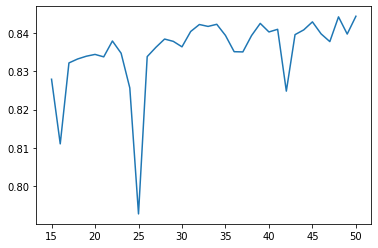

Epoch of model:50
dice score:0.8444474339485168


In [ ]:
# Plot and show best threshold, best score
plt.plot(nbr,np.array(total_dice_))
plt.show()

s = nbr[np.argmax(np.array(total_dice_))]
print("Epoch of model:{}".format(s))
print("dice score:{}".format(np.max(np.array(total_dice_))))

In [ ]:
np.argpartition(total_dice_, -5)[-5:]

array([19, 24, 30, 33, 35])

## 6 - Create the csv for submission

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def submit(net):
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = '/content/drive/MyDrive/ESSEC_Google_Drive/Cours 4ième trimestre/Intro to Deep Learning/Kaggle Competition/test_images/'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    N = len(list(os.listdir(dir)))
    with open('UNet_SUBMISSION.csv', 'w') as f:
        f.write('img,rle_mask\n')
        for index, i in enumerate(tqdm(os.listdir(dir))):
            print('{}/{}'.format(index, N))
            #img = Image.open(dir + i)
            mask = predict_mask(net, dir+i, 0.5)
            #mask = predict_img(net, img, device)
            enc = rle_encode(mask)
            f.write('{},{}\n'.format(i, enc))



In [ ]:
submit(model)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
246/5245
247/5245
248/5245
249/5245
250/5245
251/5245
252/5245
253/5245
254/5245
255/5245
256/5245
257/5245
258/5245
259/5245
260/5245
261/5245
262/5245
263/5245
264/5245
265/5245
266/5245
267/5245
268/5245
269/5245
270/5245
271/5245
272/5245
273/5245
274/5245
275/5245
276/5245
277/5245
278/5245
279/5245
280/5245
281/5245
282/5245
283/5245
284/5245
285/5245
286/5245
287/5245
288/5245
289/5245
290/5245
291/5245
292/5245
293/5245
294/5245
295/5245
296/5245
297/5245
298/5245
299/5245
300/5245
301/5245
302/5245
303/5245
304/5245
305/5245
306/5245
307/5245
308/5245
309/5245
310/5245
311/5245
312/5245
313/5245
314/5245
315/5245
316/5245
317/5245
318/5245
319/5245
320/5245
321/5245
322/5245
323/5245
324/5245
325/5245
326/5245
327/5245
328/5245
329/5245
330/5245
331/5245
332/5245
333/5245
334/5245
335/5245
336/5245
337/5245
338/5245
339/5245
340/5245
341/5245
342/5245
343/5245
344/5245
345/5245
346/5245
347/5245
348/